In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist, cosine
from scipy.ndimage import convolve1d
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import tensorflow as tf
from joblib import Parallel, delayed

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import os

import seaborn as sns
import cmocean as cmocn

%matplotlib inline

2025-09-18 23:21:29.402155: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-18 23:21:29.429614: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-18 23:21:29.429640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-18 23:21:29.430667: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-18 23:21:29.435385: I tensorflow/core/platform/cpu_feature_gua

In [2]:
#ds = xr.open_dataset('../rainFlagRemovedBuoyDataBadQualityRemovedMatchup.nc')
#ds = xr.open_dataset('goodData_QSwithTAO_with2hrStatsConv.nc')
ds = xr.open_dataset('../testMatchups_frozenFlow/rainFlagRemovedBuoyDataFrozenBadQualityRemovedMatchupAmbuguitiesAdded_waveAndGlorysAdded_manualRemovedSomeData.nc')
ds



<xarray.Dataset>
Dimensions:                                   (count: 264416)
Coordinates:
  * count                                     (count) int64 0 1 ... 295512
Data variables: (12/140)
    WDIR (TAO)                                (count) float32 ...
    WDIR_QC                                   (count) float32 ...
    WDIR_DM                                   (count) |S1 ...
    WSPD (TAO)                                (count) float32 ...
    WSPD_QC                                   (count) float32 ...
    WSPD_DM                                   (count) |S1 ...
    ...                                        ...
    WSPD_DIFF_MN (QuikSCAT - TAO)             (count) float64 ...
    WDIR_DIFF_MN (QuikSCAT - TAO)             (count) float64 ...
    cos(WDIR_DIFF_MN (QuikSCAT - TAO))        (count) float64 ...
    sin(WDIR_DIFF_MN (QuikSCAT - TAO))        (count) float64 ...
    UWND_DIFF_MN (QuikSCAT - TAO)             (count) float64 ...
    VWND_DIFF_MN (QuikSCAT - TAO)             (count) float64 ...

In [3]:
df = ds.to_dataframe()
df_orig = df.copy()

df['SST-AIRT'] = df['SST (TAO)'] - df['AIRT (TAO)']
df['VSD'] = np.sqrt(df['VSDX']**2 + df['VSDY']**2)
df['VSD_DIR'] = (np.rad2deg(np.arctan2(df['VSDY'], df['VSDX'])) + 360)%360

dummy = (df['VSD_DIR']-df['mean_WDIR']+360)%360
dummy[dummy <= -180] = dummy[dummy <= -180] + 360
dummy[dummy > 180] = dummy[dummy > 180] - 360
df['VSD_DIR-mean_WDIR']  = dummy 

df['OCN_CUR'] = np.sqrt(df['uo']**2 + df['vo']**2)
df['OCN_CUR_DIR'] = (np.rad2deg(np.arctan2(df['vo'], df['uo'])) + 360)%360
dummy = (df['OCN_CUR_DIR']-df['mean_WDIR']+360)%360
dummy[dummy <= -180] = dummy[dummy <= -180] + 360
dummy[dummy > 180] = dummy[dummy > 180] - 360
df['OCN_CUR_DIR-mean_WDIR']  = dummy 


dummy = (df['VMDR_WW']-df['mean_WDIR'] +360)%360
dummy[dummy <= -180] = dummy[dummy <= -180] + 360
dummy[dummy > 180] = dummy[dummy > 180] - 360
df['VMDR_WW-mean_WDIR'] = dummy

dummy = (df['VPED']-df['mean_WDIR']+360)%360
dummy[dummy <= -180] = dummy[dummy <= -180] + 360
dummy[dummy > 180] = dummy[dummy > 180] - 360
df['VPED-mean_WDIR'] = dummy

dummy = (df['VMDR']-df['mean_WDIR'] +360)%360
dummy[dummy <= -180] = dummy[dummy <= -180] + 360
dummy[dummy > 180] = dummy[dummy > 180] - 360
df['VMDR-mean_WDIR'] = dummy

dummy = (df['VMDR_SW1'] - df['mean_WDIR'] +360)%360
dummy[dummy <= -180] = dummy[dummy <= -180] + 360
dummy[dummy > 180] = dummy[dummy > 180] - 360
df['VMDR_SW1-mean_WDIR'] = dummy

dummy = (df['VMDR_SW2']-df['mean_WDIR'] +360)%360
dummy[dummy <= -180] = dummy[dummy <= -180] + 360
dummy[dummy > 180] = dummy[dummy > 180] - 360
df['VMDR_SW2-mean_WDIR'] = dummy

df = df.rename(columns={
    'nudge_wind_speed': 'model_speed',
    'nudge_wind_direction': 'model_dir'
})

dummy = (df['model_dir']-df['mean_WDIR']+360)%360
dummy[dummy <= -180] = dummy[dummy <= -180] + 360
dummy[dummy > 180] = dummy[dummy > 180] - 360
df['model_dir-mean_WDIR']  = dummy 
df['model_speed-mean_WSPD_10N'] = df['model_speed']-df['mean_WSPD_10N']

In [4]:
# df['cos(WDIR_DIFF (QuikSCAT - TAO))'] = np.cos(np.deg2rad(df['WDIR_DIFF (QuikSCAT - TAO)']))
# df['sin(WDIR_DIFF (QuikSCAT - TAO))'] = np.sin(np.deg2rad(df['WDIR_DIFF (QuikSCAT - TAO)']))


# for timeWindow in range(20,120,10):
#     df[f'cos(WDIR_DIFF (QuikSCAT - TAO {timeWindow} min mean))'] = np.cos(np.deg2rad(df[f'WDIR_DIFF (QuikSCAT - TAO {timeWindow} min mean)']))
#    df[f'sin(WDIR_DIFF (QuikSCAT - TAO {timeWindow} min mean))'] = np.sin(np.deg2rad(df[f'WDIR_DIFF (QuikSCAT - TAO {timeWindow} min mean)']))

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

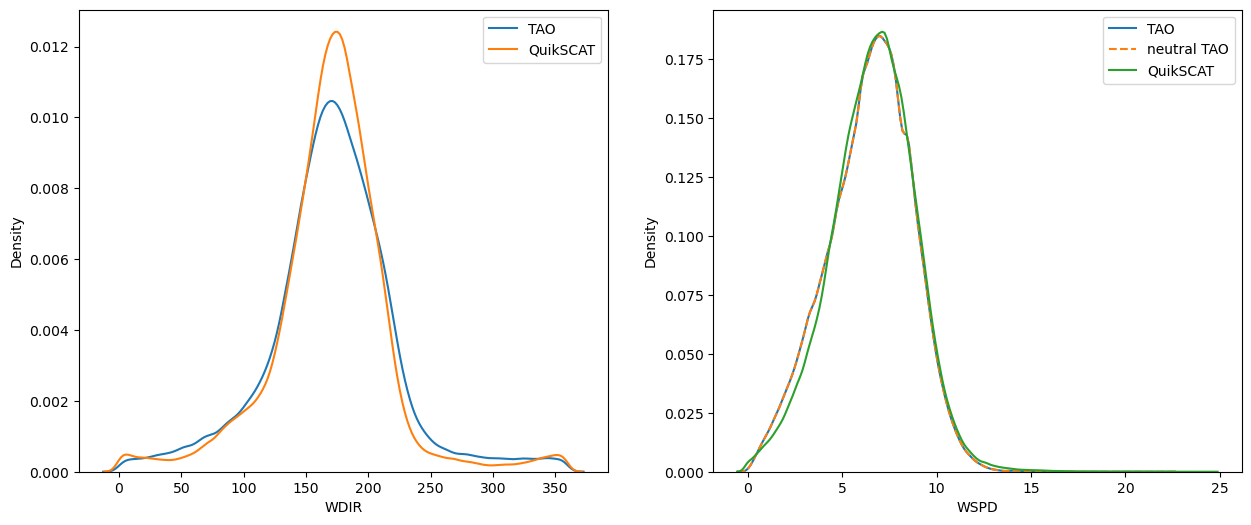

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(15,6))

ax = axes[0]
sns.kdeplot(df['WDIR_FZ (TAO)'], ax = ax, label = 'TAO')
#sns.kdeplot(df['mean WDIR 30min'], ax = ax, label = 'TAO (30 min mean)')
#sns.kdeplot(df['mean WDIR 60min'], ax = ax, label = 'TAO (1 hr mean)')
#sns.kdeplot(df['mean WDIR 120min'], ax = ax, label = 'TAO (2 hr mean)')
sns.kdeplot(df['WDIR (QuikSCAT)'], ax = ax, label = 'QuikSCAT')
ax.set_xlabel('WDIR')
ax.legend()

ax = axes[1]
sns.kdeplot(df['WSPD_10N_FZ (TAO)'], ax = ax, label = 'TAO')
#sns.kdeplot(df['mean WSPD 30min'], ax = ax, label = 'TAO (30 min mean)')
#sns.kdeplot(df['mean WSPD 60min'], ax = ax, label = 'TAO (1 hr mean)')
#sns.kdeplot(df['mean WSPD 120min'], ax = ax, label = 'TAO (2 hr mean)')

sns.kdeplot(df['WSPD_10N_FZ (TAO)'], linestyle="--", ax = ax, label = 'neutral TAO')
#sns.kdeplot(df['mean WSPD_10N 30min'], linestyle="--", ax = ax, label = 'neutral TAO (30 min mean)')
#sns.kdeplot(df['mean WSPD_10N 60min'], linestyle="--", ax = ax, label = 'neutral TAO (1 hr mean)')
#sns.kdeplot(df['mean WSPD_10N 120min'], linestyle="--", ax = ax, label = 'neutral TAO (2 hr mean)')

sns.kdeplot(df['WSPD_10N (QuikSCAT)'], ax = ax, label = 'QuikSCAT')
ax.set_xlabel('WSPD')
ax.legend()

(0.8831543589778659, 0.8657471248609911)

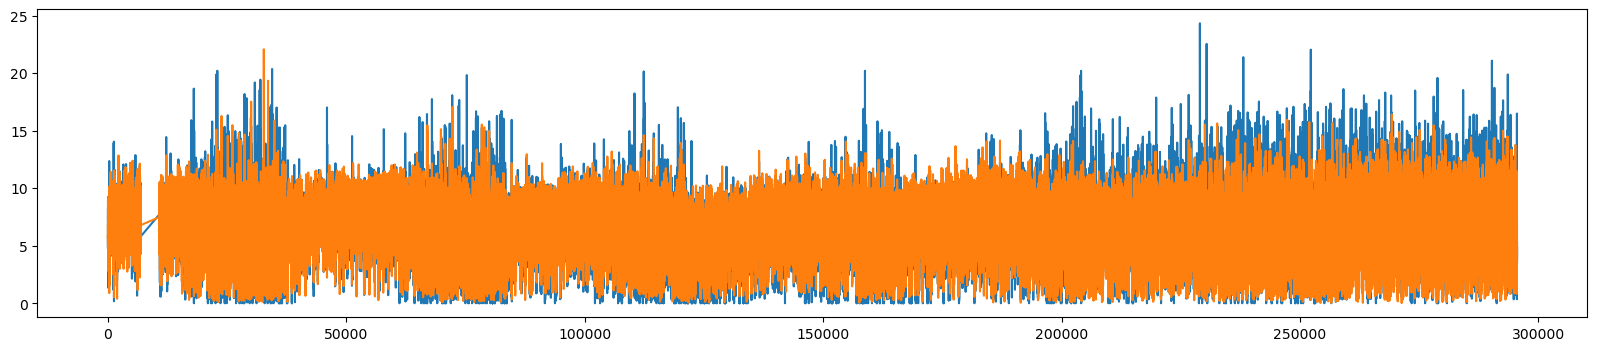

In [6]:
plt.figure(figsize=(20,4))
plt.plot(df['WSPD_10N (QuikSCAT)'])
plt.plot(df['WSPD_10N_FZ (TAO)'])

np.corrcoef(df['WSPD_10N_FZ (TAO)'], df['WSPD_10N (QuikSCAT)'])[0,1], np.corrcoef(df['WSPD_10N_FZ (TAO)'], df['WSPD_10N (QuikSCAT)'])[0,1]

(0.7088300307214119, 0.6886812733676302)

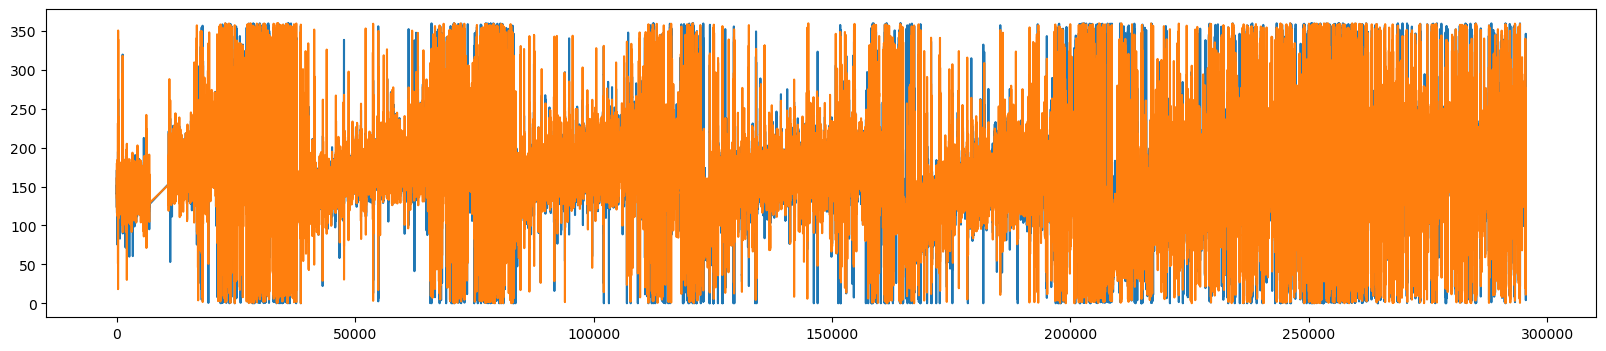

In [7]:
plt.figure(figsize=(20,4))
plt.plot(df['WDIR (QuikSCAT)'])
plt.plot(df['WDIR_FZ (TAO)'])

np.corrcoef(df['WDIR_FZ (TAO)'], df['WDIR (QuikSCAT)'])[0,1], np.corrcoef(df['WDIR_FZ (TAO)'], df['WDIR (QuikSCAT)'])[0,1]

In [8]:
selectX = ['WSPD_DIFF_FZ (QuikSCAT - TAO)',
          'cos(WDIR_DIFF_FZ (QuikSCAT - TAO))',
          'sin(WDIR_DIFF_FZ (QuikSCAT - TAO))']


X = df[selectX]

normX = (X - X.mean(axis=0))/ X.std(axis=0)

# kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
# df['label'] = kmeans.labels_

dbscan = DBSCAN(eps=0.15, min_samples= 500) ##original 
#dbscan = DBSCAN(eps=0.09, min_samples= 500)
df['label'] = dbscan.fit_predict(normX)

# # optics = OPTICS(min_samples=50 ) #cluster_method='dbscan', eps=0.25)
# # df['label'] = optics.fit_predict(normX)

# fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

# ax = axes[0]
# # ax.remove()  # Remove the existing second subplot
# # ax = fig.add_subplot(121, projection='polar')
# xlabel = 'WSPD_DIFF (QuikSCAT - TAO)'
# ylabel = 'WDIR_DIFF (QuikSCAT - TAO)'

# s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10, 
#                 hue='label', common_norm=True, cbar = True,
#                 palette = sns.color_palette("bright"), ax = ax)

# s = sns.kdeplot(df, x=xlabel, y = ylabel, levels=10, 
#                 ax = ax)

# ax.grid(visible=True, which='both', axis='both')

# ax.text(0.1, 0.95, 'A', horizontalalignment='left',
#         verticalalignment='center', transform=ax.transAxes,
#         weight = 'heavy', fontsize = 20)

# ax.set_xlim(-10,15)

# ax = axes[1]
# s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)

# ax.grid(visible=True, which='both', axis='both')
# ax.set_xlabel('cluster label')
# #ax.set_ylabel('cluster label')

# ax.text(0.1, 0.95, 'B', horizontalalignment='left',
#         verticalalignment='center', transform=ax.transAxes,
#         weight = 'heavy', fontsize = 20)


# #plt.savefig('PDF_byCluster_10min.png', dpi=100)

In [9]:
goodBad = np.array(['good' for i in range(len(df))])
print(len(goodBad))
mask = df['label'].isin([-1])
goodBad[mask] = 'bad'
df['GoodBad'] = goodBad

def getGoodBad(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:    
        goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        return f' {goodCount:3.0f},{badCount:3.0f}'
    else:
        return ''

def getBadPercent(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    
    if isPresent:
        goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        
        return badCount
    else:
        return -999

def getCount(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        count = len(subDF) #.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        return count
    else:
        return -999

264416


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

0.18214858404937673


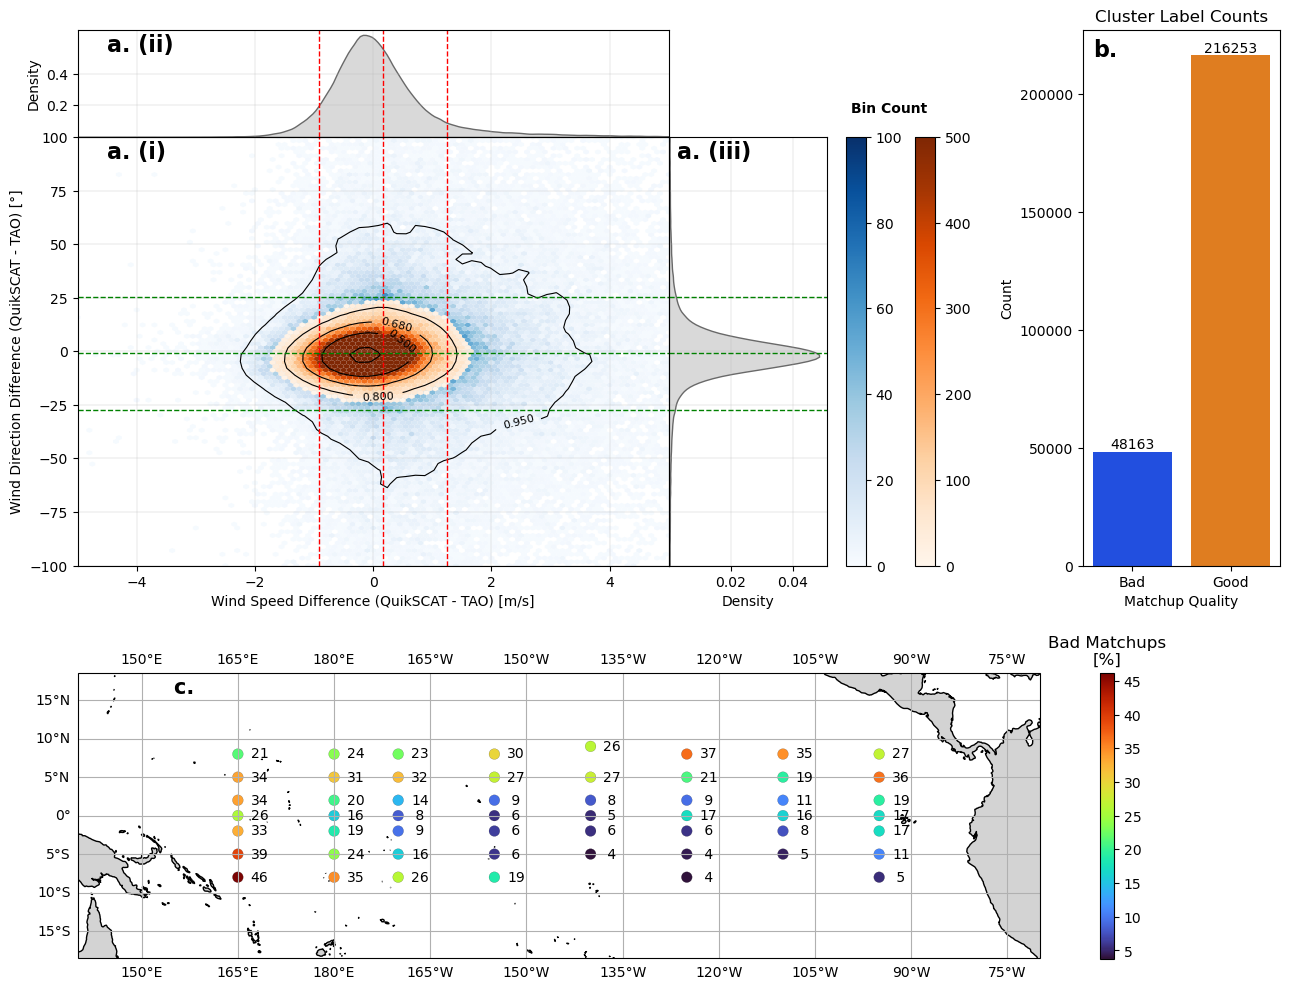

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import pandas as pd

# Example DataFrame: df must contain 'label', 'speed', 'direction'
# Replace these with your actual column names
xlabel = 'WSPD_DIFF_FZ (QuikSCAT - TAO)'
ylabel = 'WDIR_DIFF_FZ (QuikSCAT - TAO)'

# Compute mean and std
mu_speed = df[xlabel].mean()
std_speed = df[xlabel].std()
mu_dir = df[ylabel].mean()
std_dir = df[ylabel].std()

# Create overall figure
fig = plt.figure(figsize=(13, 10))
gs = gridspec.GridSpec(4, 8, width_ratios=[3, 0.8, 0.1, 0.1, 0.25, 0.1, 0.75, 1], height_ratios=[0.75, 3, 0.75, 2], wspace=0, hspace=0)

# Joint and marginals (LEFT)
ax_joint = fig.add_subplot(gs[1, 0])
ax_marg_x = fig.add_subplot(gs[0, 0], sharex=ax_joint)
ax_marg_y = fig.add_subplot(gs[1, 1], sharey=ax_joint)
ax_cb1 = fig.add_subplot(gs[1,3])
ax_cb2 = fig.add_subplot(gs[1,5])

# Countplot (RIGHT)
ax_count = fig.add_subplot(gs[0:2, -1])  # spans both rows

# -------------------------
# 1. JOINT HISTOGRAM + KDE

colors = [plt.cm.Blues, plt.cm.Oranges]
hexcounts = [100, 100]
x_min, x_max, y_min, y_max = -5, 5, -100, 100
vmins = [0, 0]
vmaxs = [100, 500]
numcontours = 5

for i, (label, ax, ax_cb) in enumerate(zip([-1, 0], [ax_joint, ax_joint], [ax_cb1, ax_cb2])):
    df_label = df[df['label'] == label]

    hb = ax.hexbin(
        x=df_label[xlabel],
        y=df_label[ylabel],
        gridsize=hexcounts[i],
        cmap=colors[i],
        mincnt=1,
        linewidths=0.01,
        edgecolors=(0, 0, 0, 0.01),
        vmin=vmins[i],            # ← custom lower limit
        vmax=vmaxs[i],             # ← custom upper limit
        extent=(x_min, x_max, y_min, y_max)
    )

    # Extract colorbar for this label
    cbar = fig.colorbar(hb, cax=ax_cb)
    
#cbar.set_label("Bin Count")
cbar.ax.text(
    0.6, 1.05,                        # x=50% of width, y=just above the top
    "Bin Count",                     # your label
    ha='right', va='bottom',        # horizontal center, baseline aligned
    fontsize=10, fontweight='bold',  # optional styling
    transform=cbar.ax.transAxes      # relative to colorbar axis
)

# Create the Joint PDF plot and capture the returned QuadContourSet object
# KDE Grid resolution
nx, ny = 64, 64

# Data
x = df[xlabel].values
y = df[ylabel].values
xy = np.vstack([x, y])

# KDE with specified bandwidth
kde = gaussian_kde(xy, bw_method=0.1)

# Grid over which to evaluate
xx, yy = np.mgrid[x_min:x_max:nx*1j, y_min:y_max:ny*1j]
grid_coords = np.vstack([xx.ravel(), yy.ravel()])
z = kde(grid_coords).reshape(xx.shape)

# Normalize z to make it a probability surface (area ≈ 1)
dx = (x_max - x_min) / nx
dy = (y_max - y_min) / ny
z_prob = z / z.sum() #/ (dx * dy)

# Flatten and sort to get cumulative distribution
z_flat = z_prob.flatten()
z_sorted = np.sort(z_flat)[::-1]  # 🔄 descending order
z_cumsum = np.cumsum(z_sorted)

# Desired probability masses for contours
mass_levels = [0.1, 0.5, 0.68, 0.8, 0.95]
mass_levels.reverse()
levels = [z_sorted[np.searchsorted(z_cumsum, mass)] for mass in mass_levels]


#levels.sort()
# Plot contours
contour = ax_joint.contour(xx, yy, z_prob, levels=levels, colors='black', linewidths=0.8)

# Label with probability instead of density
fmt = {}
for l, s in zip(contour.levels, mass_levels):
    fmt[l] = f"{s:.3f}"  # show enclosed probability

#fmt = {level: f"{mass:.3f}" for level, mass in zip(levels, mass_levels)}

ax_joint.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=8)
# # Add labels to the contour lines
# ax_joint.clabel(contour, inline=True, fontsize=8, fmt="%.2f")

# 2. MARGINAL KDEs
sns.kdeplot(data=df, x=xlabel, fill=True, color = 'dimgrey', legend=False, ax=ax_marg_x, clip = (x_min, x_max) , cut = 0, bw_adjust=0.5 )
sns.kdeplot(data=df, y=ylabel, fill=True, color = 'dimgrey', legend=False, ax=ax_marg_y, clip = (y_min, y_max) , cut = 0, bw_adjust=0.5 )

# Remove marginal axis ticks
ax_marg_x.tick_params(bottom=False, labelbottom=False)
ax_marg_y.tick_params(left=False, labelleft=False)

# Add ±1σ lines
for x in [mu_speed - std_speed, mu_speed, mu_speed + std_speed]:
    ax_joint.axvline(x, color='red', linestyle='--', linewidth=1)
    ax_marg_x.axvline(x, color='red', linestyle='--', linewidth=1)  
    ax_marg_x.set_yticks([0.2,0.4])

for y in [mu_dir - std_dir, mu_dir, mu_dir + std_dir]:
    ax_joint.axhline(y, color='green', linestyle='--', linewidth=1)
    ax_marg_y.axhline(y, color='green', linestyle='--', linewidth=1)
    ax_marg_y.set_xticks([0.02,0.04])


# Axis labels
ax_joint.set_xlabel('Wind Speed Difference (QuikSCAT - TAO) [m/s]')
ax_joint.set_ylabel("Wind Direction Difference (QuikSCAT - TAO) [°]")
ax_marg_x.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax_marg_y.tick_params(axis='y', which='both', left=False, labelleft=False)
ax_marg_x.set_xlabel(None)
ax_marg_y.set_ylabel(None)

# Label the panel
ax_joint.text(0.05, 0.95, 'a. (i)', transform=ax_joint.transAxes, fontsize=16, weight='bold')
ax_marg_x.text(0.05, 0.80, 'a. (ii)', transform=ax_marg_x.transAxes, fontsize=16, weight='bold')
ax_marg_y.text(0.05, 0.95, 'a. (iii)', transform=ax_marg_y.transAxes, fontsize=16, weight='bold')

# -------------------------
# 3. COUNTPLOT
s = sns.countplot(data=df, x='label', palette='bright', ax=ax_count)
for container in s.containers:
    s.bar_label(container)
ax_count.set_title("Cluster Label Counts")
#ax_count.set_xticks([-1, 0])                    # positions (the actual cluster labels)
ax_count.set_xticklabels(["Bad", "Good"])       # the new labels shown on the axis
ax_count.set_xlabel("Matchup Quality")
ax_count.set_ylabel("Count")
ax_count.text(0.05, 0.95, 'b.', transform=ax_count.transAxes, fontsize=16, weight='bold')

# Final adjustments

ax_joint.set_xlim(x_min, x_max)
ax_joint.set_ylim(y_min,  y_max)
ax_joint.grid(lw = 0.2)

ax_marg_x.set_xlim(x_min, x_max)
ax_marg_x.grid(lw = 0.2)

ax_marg_y.set_ylim(y_min,  y_max)
ax_marg_y.grid(lw = 0.2)

######################################################################################################################

import cartopy.crs as ccrs
import cartopy.feature as cfeature 
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
dotSize = 60
slw = 0.1

latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

ax = fig.add_subplot(gs[3,:], projection=ccrs.PlateCarree(central_longitude=180))
ax.set_aspect(1.2)

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax.add_feature(land)


ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
gridlines.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gridlines.xformatter = LONGITUDE_FORMATTER
ax.add_feature(land)
ax.coastlines()
plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    if txt != '': 
        badPercent = getBadPercent(lat, lon, df)
        #print(badPercent)
        txt = f'{badPercent:2.0f}'
        ax.text(xpos+2, lat-0.5, txt)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, badPercent]])), axis = 0)

x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', linewidths=slw, cmap=cm.turbo)    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Bad Matchups\n[%]')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'c. ', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


plt.tight_layout()

plt.savefig('frozen_clustering.pdf', dpi=100)
print(len(df.loc[df['label'] == -1])/len(df))

In [12]:
def getSpeedDifference(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'WSPD_10N_FZ (TAO)'
        else:
            TAOlabel = f'mean WSPD_10N {timeWindow}min'
        QSspeed = subDF['WSPD_10N (QuikSCAT)'].to_numpy()
        TAOspeed = subDF[TAOlabel].to_numpy()
        corr = np.mean(QSspeed) - np.mean(TAOspeed)
        return corr
    else:
        return -999

def getSpeedRMSE(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'WSPD_10N_FZ (TAO)'
        else:
            TAOlabel = f'mean WSPD_10N {timeWindow}min'
        QSspeed = subDF['WSPD_10N (QuikSCAT)'].to_numpy()
        TAOspeed = subDF[TAOlabel].to_numpy()
        corr = np.sqrt(np.mean((QSspeed - TAOspeed)**2))
        return corr
    else:
        return -999


def getSpeedCorrelation(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'WSPD_10N_FZ (TAO)'
        else:
            TAOlabel = f'mean WSPD_10N {timeWindow}min'
        QSspeed = subDF['WSPD_10N (QuikSCAT)'].to_numpy()
        TAOspeed = subDF[TAOlabel].to_numpy()
        corr = np.corrcoef(QSspeed, TAOspeed)[0,1]
        return corr
    else:
        return -999

#########################################################################################3

def getDirDifference(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'WDIR_FZ (TAO)'
        else:
            TAOlabel = f'mean WDIR {timeWindow}min'
        QSdir = subDF['WDIR (QuikSCAT)'].to_numpy()
        TAOdir = subDF[TAOlabel].to_numpy()
        corr = np.mean(QSdir)- np.mean(TAOdir)
        return corr
    else:
        return -999


def getDirRMSE(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'WDIR_FZ (TAO)'
        else:
            TAOlabel = f'mean WDIR {timeWindow}min'
        QSdir = subDF['WDIR (QuikSCAT)'].to_numpy()
        TAOdir = subDF[TAOlabel].to_numpy()
        diff = QSdir - TAOdir
        diff[diff>180] -= 360
        diff[diff<-180] += 360
        corr = np.sqrt(np.mean(diff**2))
        return corr
    else:
        return -999
        
def getDirCorrelation(lat, lon, df, timeWindow=10, isPresent = False):
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'WDIR_FZ (TAO)'
        else:
            TAOlabel = f'mean WDIR {timeWindow}min'
        QSdir = subDF['WDIR (QuikSCAT)'].to_numpy()
        TAOdir = subDF[TAOlabel].to_numpy()
        corr = np.corrcoef(QSdir, TAOdir)[0,1]
        return corr
    else:
        return -999



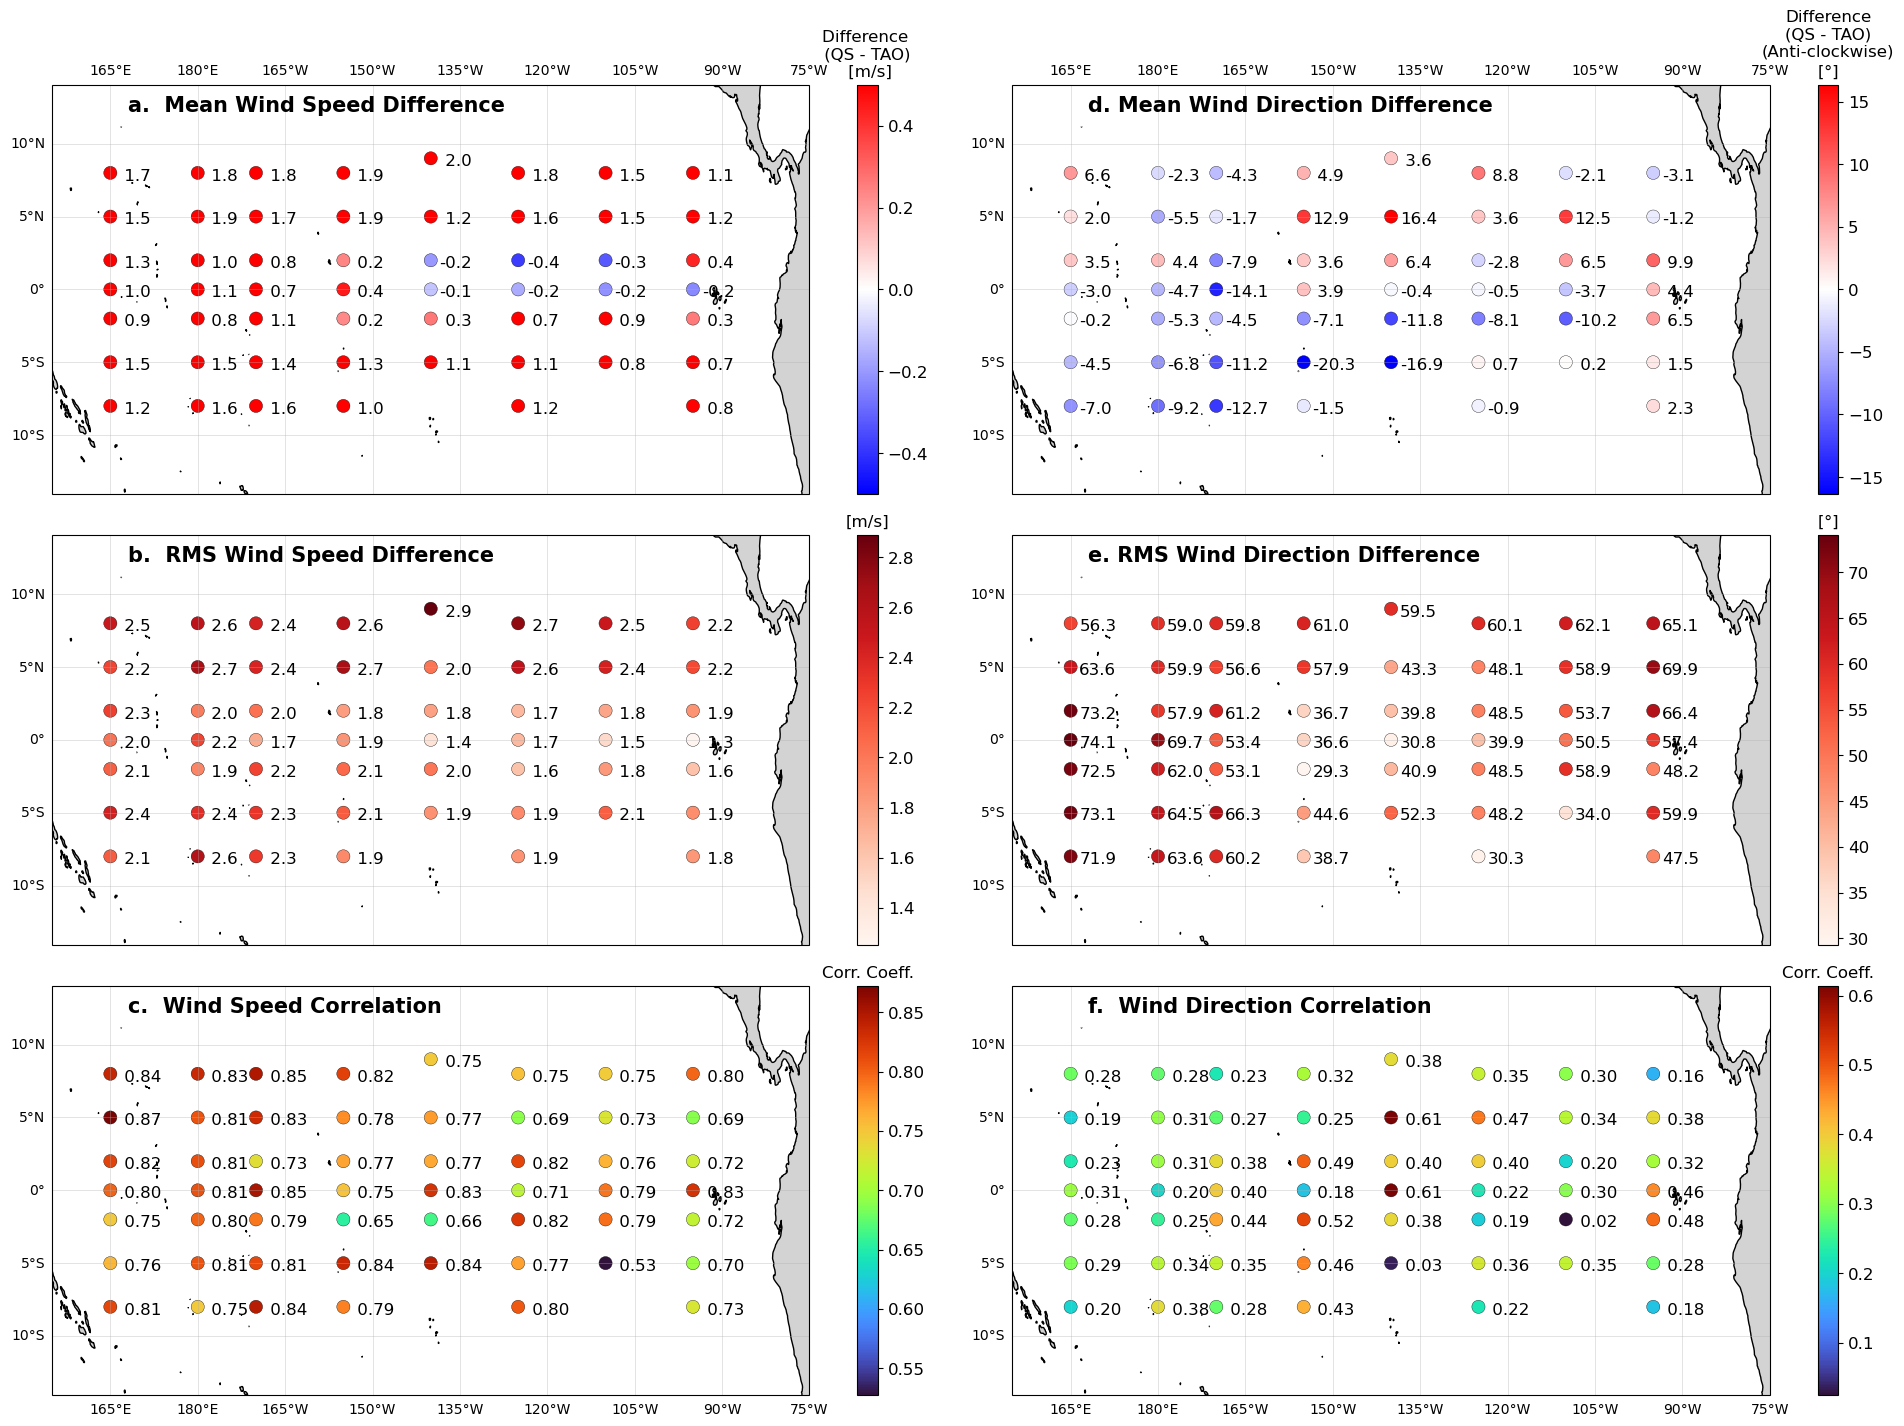

In [15]:
subDF = df.loc[df['label'] == -1]
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

import cartopy.crs as ccrs
import cartopy.feature as cfeature 
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

fig, axes = plt.subplots(nrows = 3, 
                       ncols = 2, 
                        figsize = (22*0.9,18*0.8),
                         sharex = True,
                         sharey = True, 
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180),  
                                   "aspect": 2.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)


fontSize = 15
fsz = 12
tickFsz = 10
dotSize = 90
slw = 0.25
cbFs = 12
###################################################################################################################
ax = axes[0,0] 

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
# gridlines = ax.gridlines(draw_labels=True, linewidth=0.5, alpha = 0.5)
# gridlines.xlocator = plt.FixedLocator([150, 180, 210, 240, 270])
# ax.coastlines()

gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = True   
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedDifference(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', linewidths=slw, cmap=cm.bwr, vmin= -0.5, vmax= 0.5)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('Difference \n (QS - TAO) \n [m/s]')

ax.text(0.1, 0.95, 'a.  Mean Wind Speed Difference', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################
ax = axes[1,0]

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = False   
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedRMSE(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', linewidths=slw, cmap=cm.Reds)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('[m/s]')

ax.text(0.1, 0.95, 'b.  RMS Wind Speed Difference', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################
ax = axes[2,0]

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = False  
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedCorrelation(lat, lon, subDF)
    #print(corr)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:5.2f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', linewidths=slw, cmap=cm.turbo)# vmin=0.40, vmax=0.85,)
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'c.  Wind Speed Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################
###################################################################################################################
ax = axes[0,1] 

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = True  
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirDifference(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', linewidths=slw, cmap=cm.bwr, vmin= -np.max(plotList[:,2]), vmax= np.max(plotList[:,2]))
    
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('Difference\n(QS - TAO)\n(Anti-clockwise)\n' + r'[$\degree$]')

ax.text(0.1, 0.95, 'd. Mean Wind Direction Difference', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)

###################################################################################################################
ax = axes[1,1]

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = False  
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirRMSE(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', linewidths=slw, cmap=cm.Reds)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title(r'[$\degree$]')

ax.text(0.1, 0.95, 'e. RMS Wind Direction Difference', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################
ax = axes[2,1]

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = False  
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirCorrelation(lat, lon, subDF)
    #print(corr)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:5.2f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', linewidths=slw, cmap=cm.turbo)# vmin=0.40, vmax=0.85,)
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'f.  Wind Direction Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################

plt.subplots_adjust(left = 0.03, right = 1, top =0.93 , bottom = 0.02, wspace=0 , hspace=0.1)

plt.savefig('frozen_BasicStats_bad.pdf', dpi=100)

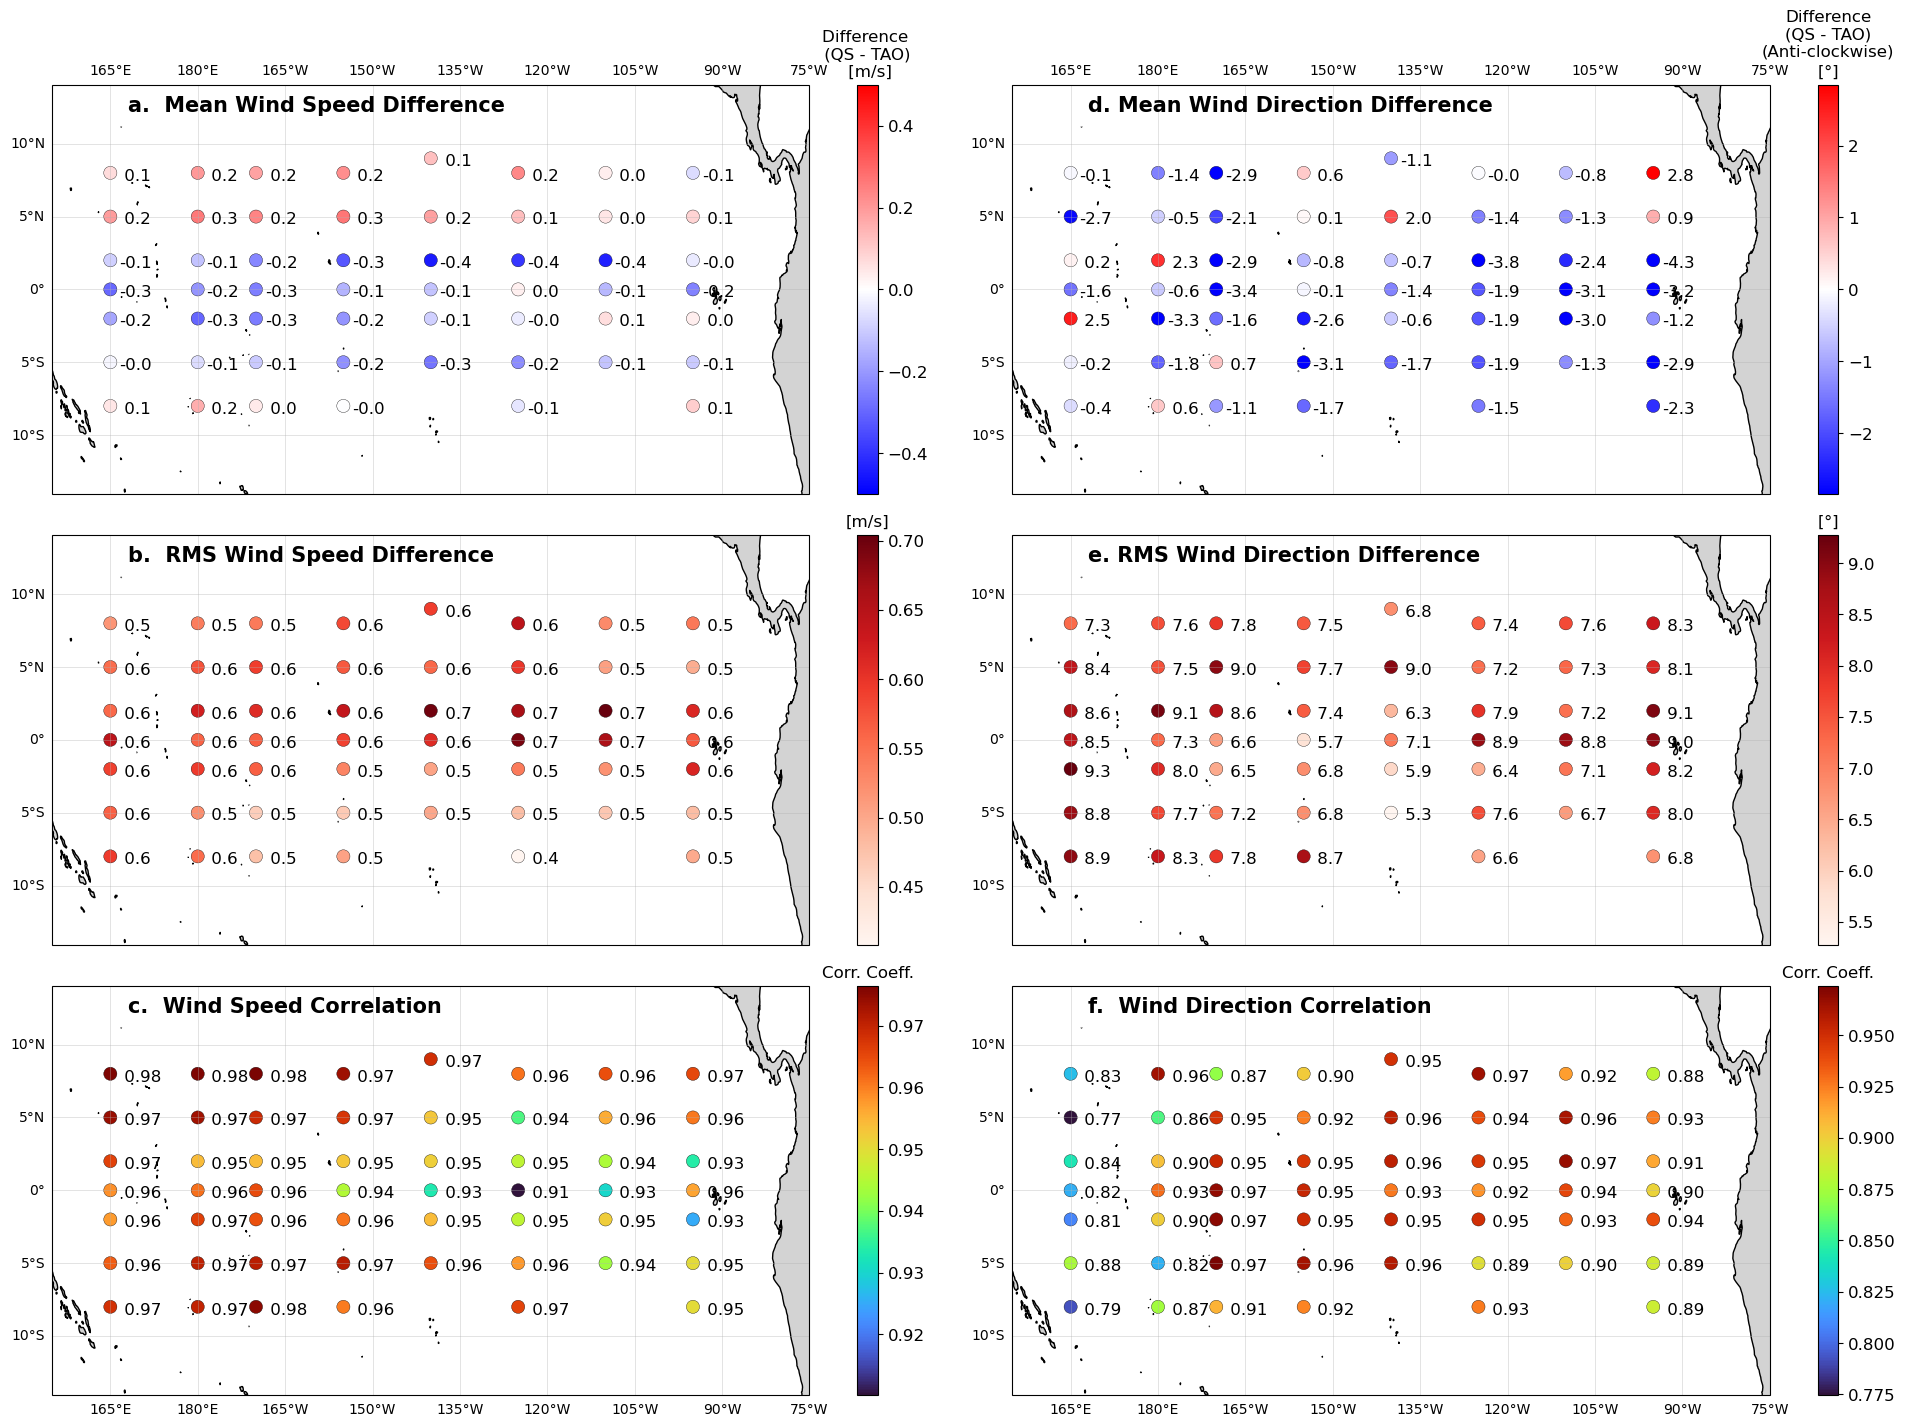

In [16]:
subDF = df.loc[df['label'] == 0]
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

import cartopy.crs as ccrs
import cartopy.feature as cfeature 
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

fig, axes = plt.subplots(nrows = 3, 
                       ncols = 2, 
                        figsize = (22*0.9,18*0.8),
                         sharex = True,
                         sharey = True, 
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180),  
                                   "aspect": 2.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)


fontSize = 15
fsz = 12
tickFsz = 10
dotSize = 90
slw = 0.25
cbFs = 12
###################################################################################################################
ax = axes[0,0] 

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
# gridlines = ax.gridlines(draw_labels=True, linewidth=0.5, alpha = 0.5)
# gridlines.xlocator = plt.FixedLocator([150, 180, 210, 240, 270])
# ax.coastlines()

gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = True   
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedDifference(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', linewidths=slw, cmap=cm.bwr, vmin= -0.5, vmax= 0.5)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('Difference \n (QS - TAO) \n [m/s]')

ax.text(0.1, 0.95, 'a.  Mean Wind Speed Difference', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################
ax = axes[1,0]

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = False   
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedRMSE(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', linewidths=slw, cmap=cm.Reds)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('[m/s]')

ax.text(0.1, 0.95, 'b.  RMS Wind Speed Difference', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################
ax = axes[2,0]

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = False  
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedCorrelation(lat, lon, subDF)
    #print(corr)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:5.2f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', linewidths=slw, cmap=cm.turbo)# vmin=0.40, vmax=0.85,)
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'c.  Wind Speed Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################
###################################################################################################################
ax = axes[0,1] 

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = True  
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirDifference(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', linewidths=slw, cmap=cm.bwr, vmin= -np.max(plotList[:,2]), vmax= np.max(plotList[:,2]))
    
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('Difference\n(QS - TAO)\n(Anti-clockwise)\n' + r'[$\degree$]')

ax.text(0.1, 0.95, 'd. Mean Wind Direction Difference', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)

###################################################################################################################
ax = axes[1,1]

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = False  
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirRMSE(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:4.1f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', linewidths=slw, cmap=cm.Reds)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title(r'[$\degree$]')

ax.text(0.1, 0.95, 'e. RMS Wind Direction Difference', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################
ax = axes[2,1]

ax.add_feature(land)

ax.set_extent([155, -75, -6, 6]) 
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.xlocator = plt.FixedLocator([150, 165, 180, -165, -150, -135, -120, -105, -90, -75])
gl.ylocator = plt.FixedLocator([-10, -5, 0, 5, 10])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': tickFsz}
gl.ylabel_style = {'size': tickFsz}
gl.top_labels = False  
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
ax.coastlines()

plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirCorrelation(lat, lon, subDF)
    #print(corr)
    if corr != -999: 
        ax.text(xpos+1.5, lat-0.5, f'{corr:5.2f}', fontsize = fsz)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, corr]])), axis = 0)
        
x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', linewidths=slw, cmap=cm.turbo)# vmin=0.40, vmax=0.85,)
cb = plt.colorbar(x, ax = ax)
cb.ax.tick_params(labelsize=cbFs)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'f.  Wind Direction Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = fontSize)


###################################################################################################################

plt.subplots_adjust(left = 0.03, right = 1, top =0.93 , bottom = 0.02, wspace=0 , hspace=0.1)

plt.savefig('frozen_BasicStats_good.pdf', dpi=100)

In [17]:
# df['SST - AIRT (TAO)'] = df['SST (TAO)'] - df['AIRT (TAO)']

# df.rename(columns={'std_WSPD': 'std. dev. WSPD 120min',
#                    'std_cosWDIR': 'std. dev. cosWDIR 120min',
#                    'std_sinWDIR': 'std. dev. sinWDIR 120min'}, inplace=True)

# fig, axes = plt.subplots(nrows=2, ncols =3, sharex = False, figsize=(15,7))
# histkind = "stack"
# cmap = plt.get_cmap('coolwarm').copy()
# cmap.set_bad('white')
# custom_bins_RH = np.linspace(60,100,50)
# custom_bins_SSTmAIRT = np.linspace(-2,5,50)
# custom_bins_U10x = np.linspace(-10,10,50)
# ny = 10
# stack_order = {'good', 'bad'}

# ################################################################################################
# ################################################################################################

# xlabel = 'RELH (TAO)'
# title = 'For Buoy locations lon < -165 E '
# ax = axes[0,0]
# subDF = df.copy()
# #subDF = df.loc[df['WSPD (TAO)'] > 2]
# subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# # goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# # badDF = subDF.loc[subDF['GoodBad'] == 'bad']

# sns.kdeplot(subDF, x=xlabel, 
#              #clip = (60,100), cut = 0, bw_adjust=0.5,
#              hue='Matchup Agreement', 
#              #multiple=histkind,
#              palette = {'good': 'green', 'bad': 'red'}, 
#             legend=False,
#              #hue_order=stack_order,
#              common_norm = False, 
#              ax = ax)
# ax.set_xlim(60, 100)
# #ax.set_title(title)
# #x.set_xlabel('TAO Relative Humidity')
# #ax.set_ylabel('')
# ax.grid(visible=True, which='major')
# ax.text(0.05, 0.9, 'A.', horizontalalignment='left',
#         verticalalignment='center', transform=ax.transAxes,
#         weight = 'heavy', fontsize = 15)

# xlabel = 'Zonal Neutral Wind Speed (TAO)'
# ax = axes[0,1]

# sns.kdeplot(subDF, x=xlabel, 
#              #clip = (-10,10),cut = 0, bw_adjust=0.5, 
#              hue='Matchup Agreement', 
#              #multiple=histkind,
#              palette = {'good': 'green', 'bad': 'red'}, 
#             legend=False,
#              #hue_order=stack_order,
#              common_norm = False, 
#              ax = ax)
# ax.set_xlim(-15, 10)
# #ax.set_title(title)
# #ax.set_xlabel('TAO Zonal winds')
# ax.set_ylabel('')
# ax.grid(visible=True, which='major')
# ax.text(0.05, 0.9, 'B.', horizontalalignment='left',
#         verticalalignment='center', transform=ax.transAxes,
#         weight = 'heavy', fontsize = 15)

# xlabel = 'SST - AIRT (TAO)'
# ax = axes[0,2]

# sns.kdeplot(subDF, x=xlabel, 
#              #clip = (-2,5),cut = 0, bw_adjust=0.5, 
#              hue='Matchup Agreement', 
#              #multiple=histkind,
#              palette = {'good': 'green', 'bad': 'red'},
#              legend=False,
#              #hue_order=stack_order,
#              common_norm = False, 
#              ax = ax)

# ax.set_xlim(-2, 5)
# #ax.set_title(title)
# #ax.set_xlabel('TAO Zonal winds')
# ax.set_ylabel('')
# ax.grid(visible=True, which='major')
# ax.text(0.05, 0.9, 'C.', horizontalalignment='left',
#         verticalalignment='center', transform=ax.transAxes,
#         weight = 'heavy', fontsize = 15)


# ####################################################################################
# xlabel = 'std. dev. WSPD 120min'
# ax = axes[1,0]

# sns.kdeplot(subDF, x=xlabel, 
#              #bins= custom_bins_RH, 
#              hue='Matchup Agreement', 
#              #multiple=histkind,
#              palette = {'good': 'green', 'bad': 'red'}, 
#             legend=False,
#              #hue_order=stack_order,
#              common_norm = False, 
#              ax = ax)
# ax.set_xlim(-0.1, 3)
# #ax.set_title(title)
# ax.set_xlabel('std. dev. Wind Speed [120min window] (TAO)')
# #ax.set_ylabel('')
# ax.grid(visible=True, which='major')
# ax.text(0.05, 0.9, 'D', horizontalalignment='left',
#         verticalalignment='center', transform=ax.transAxes,
#         weight = 'heavy', fontsize = 15)

# xlabel = 'std. dev. cosWDIR 120min'
# ax = axes[1,1]

# sns.kdeplot(subDF, x=xlabel, 
#              #bins= custom_bins_RH, 
#              hue='Matchup Agreement', 
#              #multiple=histkind,
#              palette = {'good': 'green', 'bad': 'red'}, 
#             legend=False,
#              #hue_order=stack_order,
#              common_norm = False, 
#              ax = ax)
# ax.set_xlim(-0.05, 0.4)
# #ax.set_title(title)
# ax.set_xlabel('std. dev. cos(Wind Direction) [120min window] (TAO)')
# ax.set_ylabel('')
# ax.grid(visible=True, which='major')
# ax.text(0.05, 0.9, 'E.', horizontalalignment='left',
#         verticalalignment='center', transform=ax.transAxes,
#         weight = 'heavy', fontsize = 15)

# xlabel = 'std. dev. sinWDIR 120min'
# ax = axes[1,2]

# sns.kdeplot(subDF, x=xlabel, 
#              #bins= custom_bins_RH, 
#              hue='Matchup Agreement', 
#              #multiple=histkind,
#              palette = {'good': 'green', 'bad': 'red'}, 
#              legend=False,
#              #hue_order=stack_order,
#              common_norm = False, 
#              ax = ax)
# ax.set_xlim(-0.05, 0.6)
# #ax.set_title(title)
# ax.set_xlabel('std. dev. sin(Wind Direction) [120min window] (TAO)')
# ax.set_ylabel('')
# ax.grid(visible=True, which='major')
# ax.text(0.05, 0.9, 'F.', horizontalalignment='left',
#         verticalalignment='center', transform=ax.transAxes,
#         weight = 'heavy', fontsize = 15)

# plt.subplots_adjust(left=0.05, bottom=0.18, right=0.98, top=0.9, wspace=0.20, hspace=0.5)

# # 🌟 Add a single common legend
# from matplotlib.lines import Line2D

# # Custom legend handles
# custom_lines = [
#     Line2D([0], [0], color='green', lw=2, label='good'),
#     Line2D([0], [0], color='red', lw=2, label='bad')
# ]

# # Create the custom legend
# fig.legend(
#     handles=custom_lines,
#     loc='lower center',
#     ncol=len(custom_lines),
#     bbox_to_anchor=(0.5, 0.01),
#     title='Matchup'
# )
# plt.savefig('PDF_goodBadForRH_SSTmAIRT_stdDevs.pdf', dpi = 100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

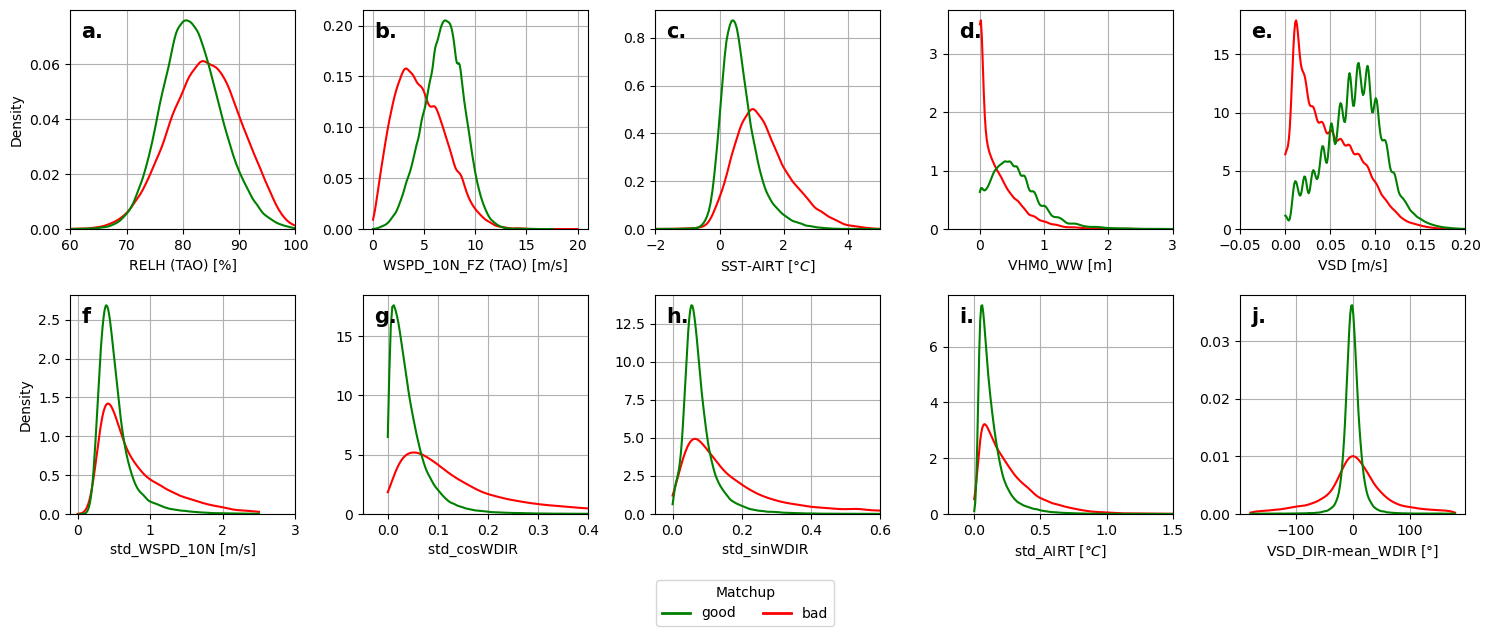

In [18]:
histkind = "stack"

cmap = plt.get_cmap('coolwarm').copy()
cmap.set_bad('white')
custom_bins_RH = np.linspace(60,100,50)
custom_bins_SSTmAIRT = np.linspace(-2,5,50)
custom_bins_U10x = np.linspace(-10,10,50)

subDF = df.copy()
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})

ny = 10
stack_order = {'good', 'bad'}

################################################################################################
################################################################################################
fig, axes = plt.subplots(nrows=2, ncols =5, sharex = False, figsize=(15,7))


xlabel = 'RELH (TAO)'
units = '[%]'
title = 'For Buoy locations lon < -165 E '

ax = axes[0,0]
sns.kdeplot(subDF, x=xlabel, 
             #clip = (60,100), cut = 0, bw_adjust=0.5,
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)

ax.set_xlim(60, 100)
ax.set_xlabel(f'{xlabel} {units}')
ax.grid(visible=True, which='major')
ax.text(0.05, 0.9, 'a.', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'WSPD_10N_FZ (TAO)'
units = '[m/s]'
ax = axes[0,1]

sns.kdeplot(subDF, x=xlabel, clip=(0, 20),
             #clip = (-10,10),cut = 0, bw_adjust=0.5, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)

ax.set_xlabel(f'{xlabel} {units}')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.05, 0.9, 'b.', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'SST-AIRT'
units = r'[$\degree C$]'
ax = axes[0,2]

sns.kdeplot(subDF, x=xlabel, 
             #clip = (-2,5),cut = 0, bw_adjust=0.5, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'},
             legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)

ax.set_xlim(-2, 5)
#ax.set_title(title)
ax.set_xlabel(f'{xlabel} {units}')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.05, 0.9, 'c.', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel =  'VHM0_WW' #dir. diff. with VSD'
units = '[m]'
ax = axes[0,3]

sns.kdeplot(subDF, x=xlabel, clip = (0,3),
             #clip = (-2,5),cut = 0, bw_adjust=0.5, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'},
             legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)

ax.set_xlim([-0.5, 3])
#ax.set_title(title)
ax.set_xlabel(f'{xlabel} {units}')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.05, 0.9, 'd.', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


xlabel = 'VSD'
units = '[m/s]'
ax = axes[0,4]

sns.kdeplot(subDF, x=xlabel, clip=(0, 0.20),
             #clip = (-2,5),cut = 0, bw_adjust=0.5, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'},
             legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)

ax.set_xlim(-0.05, 0.20)
#ax.set_title(title)
ax.set_xlabel(f'{xlabel} {units}')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.05, 0.9, 'e.', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

####################################################################################
xlabel = 'std_WSPD_10N'
units = '[m/s]'
ax = axes[1,0]

sns.kdeplot(subDF, x=xlabel, clip=(0, 2.5),
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
ax.set_xlim(-0.1, 3)
#ax.set_title(title)
ax.set_xlabel(f'{xlabel} {units}')
#ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.05, 0.9, 'f', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'std_cosWDIR'
units = ''
ax = axes[1,1]

sns.kdeplot(subDF, x=xlabel, clip=(0, 0.6),
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
ax.set_xlim(-0.05, 0.4)
#ax.set_title(title)
ax.set_xlabel(f'{xlabel} {units}')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.05, 0.9, 'g.', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'std_sinWDIR'
units = ''
ax = axes[1,2]

sns.kdeplot(subDF, x=xlabel, clip=(0, 0.6),
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
ax.set_xlim(-0.05, 0.6)
#ax.set_title(title)
ax.set_xlabel(f'{xlabel} {units}')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.05, 0.9, 'h.', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


xlabel =  'std_AIRT' #dir. diff. with VSD'
units = r'[$\degree C$]'
ax = axes[1,3]

sns.kdeplot(subDF, x=xlabel, 
             clip = (0,1.5), #cut = 0, bw_adjust=0.5, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'},
             legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)

ax.set_xlim([-0.2, 1.5])
#ax.set_title(title)
ax.set_xlabel(f'{xlabel} {units}')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.05, 0.9, 'i.', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


xlabel =  'VSD_DIR-mean_WDIR'
units = r'[$\degree$]'

ax = axes[1,4]

sns.kdeplot(subDF, x=xlabel, clip=(-180,180),
             #clip = (-2,5),cut = 0, bw_adjust=0.5, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'},
             legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)

#ax.set_xlim(-2, 5)
#ax.set_title(title)
ax.set_xlabel(f'{xlabel} {units}')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.05, 0.9, 'j.', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

plt.subplots_adjust(left=0.05, bottom=0.18, right=0.98, top=0.9, wspace=0.3, hspace=0.3)

# 🌟 Add a single common legend
from matplotlib.lines import Line2D

# Custom legend handles
custom_lines = [
    Line2D([0], [0], color='green', lw=2, label='good'),
    Line2D([0], [0], color='red', lw=2, label='bad')
]

# Create the custom legend
fig.legend(
    handles=custom_lines,
    loc='lower center',
    ncol=len(custom_lines),
    bbox_to_anchor=(0.5, 0.01),
    title='Matchup'
)
plt.savefig('frozen_PDF_goodBad.pdf', dpi = 100)

In [19]:
ds

<xarray.Dataset>
Dimensions:                                   (count: 264416)
Coordinates:
  * count                                     (count) int64 0 1 ... 295512
Data variables: (12/140)
    WDIR (TAO)                                (count) float32 140.6 ... 143.2
    WDIR_QC                                   (count) float32 2.0 2.0 ... 2.0
    WDIR_DM                                   (count) |S1 b'D' b'D' ... b'D'
    WSPD (TAO)                                (count) float32 6.79 5.46 ... 4.23
    WSPD_QC                                   (count) float32 2.0 2.0 ... 2.0
    WSPD_DM                                   (count) |S1 b'D' b'D' ... b'D'
    ...                                        ...
    WSPD_DIFF_MN (QuikSCAT - TAO)             (count) float64 0.5042 ... -0.0...
    WDIR_DIFF_MN (QuikSCAT - TAO)             (count) float64 3.404 ... -33.41
    cos(WDIR_DIFF_MN (QuikSCAT - TAO))        (count) float64 0.9982 ... 0.8347
    sin(WDIR_DIFF_MN (QuikSCAT - TAO))        (count) float64 0.05937 ... -0....
    UWND_DIFF_MN (QuikSCAT - TAO)             (count) float64 -0.6515 ... 2.125
    VWND_DIFF_MN (QuikSCAT - TAO)             (count) float64 0.01825 ... 1.685

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

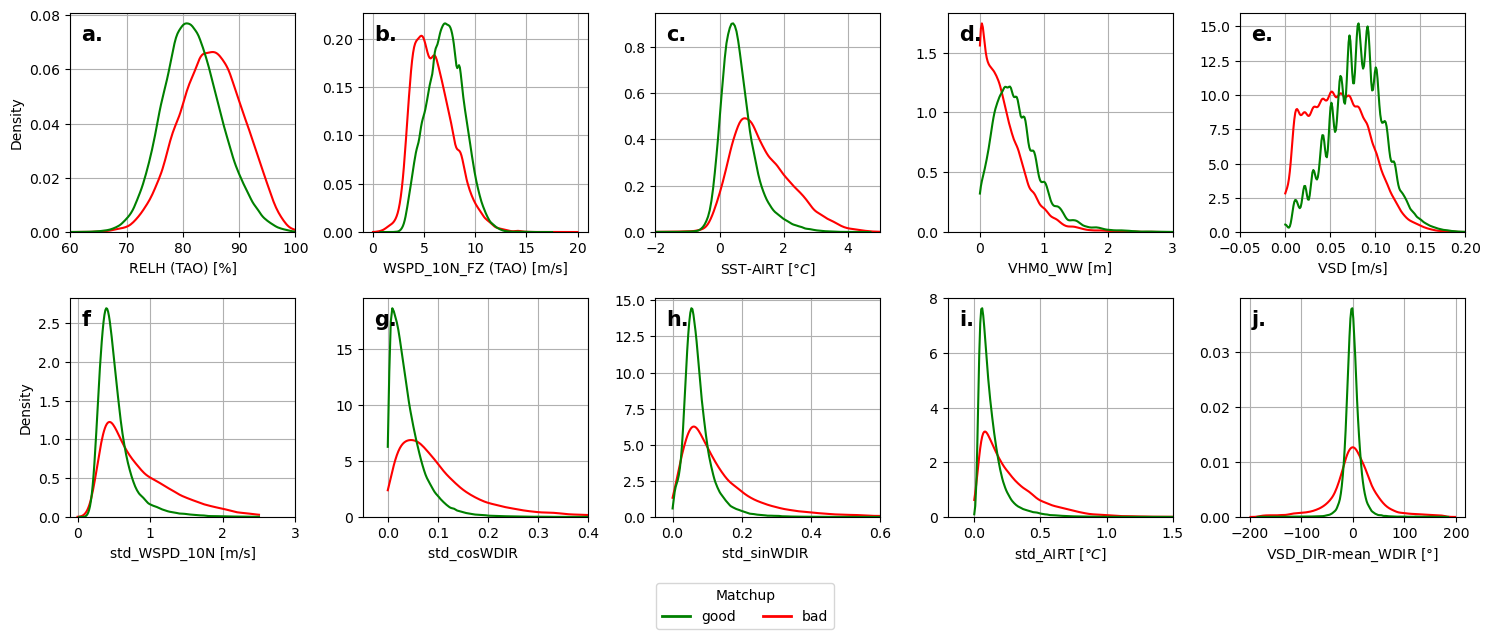

In [20]:
# df['SST - AIRT (TAO)'] = df['SST (TAO)'] - df['AIRT (TAO)']

# df.rename(columns={'std_WSPD': 'std. dev. WSPD 120min',
#                    'std_cosWDIR': 'std. dev. cosWDIR 120min',
#                    'std_sinWDIR': 'std. dev. sinWDIR 120min'}, inplace=True)


#subDF = df.loc[np.abs(df['LATITUDE'])<2]
subDF = df.loc[df['WSPD (TAO)'] > 3]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})


fig, axes = plt.subplots(nrows=2, ncols =5, sharex = False, figsize=(15,7))
histkind = "stack"
cmap = plt.get_cmap('coolwarm').copy()
cmap.set_bad('white')
custom_bins_RH = np.linspace(60,100,50)
custom_bins_SSTmAIRT = np.linspace(-2,5,50)
custom_bins_U10x = np.linspace(-10,10,50)
ny = 10
stack_order = {'good', 'bad'}

################################################################################################
################################################################################################

xlabel = 'RELH (TAO)'
units = '[%]'
ax = axes[0,0]

sns.kdeplot(subDF, x=xlabel, 
             #clip = (60,100), cut = 0, bw_adjust=0.5,
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
ax.set_xlim(60, 100)
#ax.set_title(title)
ax.set_xlabel(f'{xlabel} {units}')
#ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.05, 0.9, 'a.', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'WSPD_10N_FZ (TAO)'
units = '[m/s]'
ax = axes[0,1]

sns.kdeplot(subDF, x=xlabel, clip=(0, 20),
             #clip = (-10,10),cut = 0, bw_adjust=0.5, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_xlim(-15, 10)
#ax.set_title(title)
ax.set_xlabel(f'{xlabel} {units}')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.05, 0.9, 'b.', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'SST-AIRT'
units = r'[$\degree C$]'
ax = axes[0,2]

sns.kdeplot(subDF, x=xlabel, 
             #clip = (-2,5),cut = 0, bw_adjust=0.5, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'},
             legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)

ax.set_xlim(-2, 5)
#ax.set_title(title)
ax.set_xlabel(f'{xlabel} {units}')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.05, 0.9, 'c.', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel =  'VHM0_WW' #dir. diff. with VSD'
units = '[m]'
ax = axes[0,3]

sns.kdeplot(subDF, x=xlabel, clip = (0,3),
             #clip = (-2,5),cut = 0, bw_adjust=0.5, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'},
             legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)

ax.set_xlim([-0.5, 3])
#ax.set_title(title)
ax.set_xlabel(f'{xlabel} {units}')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.05, 0.9, 'd.', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


xlabel = 'VSD'
units = '[m/s]'
ax = axes[0,4]

sns.kdeplot(subDF, x=xlabel, clip=(0, 0.20),
             #clip = (-2,5),cut = 0, bw_adjust=0.5, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'},
             legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)

ax.set_xlim(-0.05, 0.20)
#ax.set_title(title)
ax.set_xlabel(f'{xlabel} {units}')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.05, 0.9, 'e.', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

####################################################################################
xlabel = 'std_WSPD_10N'
units = '[m/s]'
ax = axes[1,0]

sns.kdeplot(subDF, x=xlabel, clip=(0, 2.5),
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
ax.set_xlim(-0.1, 3)
#ax.set_title(title)
ax.set_xlabel(f'{xlabel} {units}')
#ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.05, 0.9, 'f', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'std_cosWDIR'
units = ''
ax = axes[1,1]

sns.kdeplot(subDF, x=xlabel, clip=(0, 0.6),
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
ax.set_xlim(-0.05, 0.4)
#ax.set_title(title)
ax.set_xlabel(f'{xlabel} {units}')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.05, 0.9, 'g.', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'std_sinWDIR'
units = ''
ax = axes[1,2]

sns.kdeplot(subDF, x=xlabel, clip=(0, 0.6),
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
ax.set_xlim(-0.05, 0.6)
#ax.set_title(title)
ax.set_xlabel(f'{xlabel} {units}')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.05, 0.9, 'h.', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


xlabel =  'std_AIRT' #dir. diff. with VSD'
units = r'[$\degree C$]'
ax = axes[1,3]

sns.kdeplot(subDF, x=xlabel, 
             clip = (0,1.5), #cut = 0, bw_adjust=0.5, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'},
             legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)

ax.set_xlim([-0.2, 1.5])
#ax.set_title(title)
ax.set_xlabel(f'{xlabel} {units}')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.05, 0.9, 'i.', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


xlabel =  'VSD_DIR-mean_WDIR'
units = r'[$\degree$]'

ax = axes[1,4]

sns.kdeplot(subDF, x=xlabel, 
             #clip = (-2,5),cut = 0, bw_adjust=0.5, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'},
             legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)

#ax.set_xlim(-2, 5)
#ax.set_title(title)
ax.set_xlabel(f'{xlabel} {units}')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.05, 0.9, 'j.', horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

plt.subplots_adjust(left=0.05, bottom=0.18, right=0.98, top=0.9, wspace=0.3, hspace=0.3)

# 🌟 Add a single common legend
from matplotlib.lines import Line2D

# Custom legend handles
custom_lines = [
    Line2D([0], [0], color='green', lw=2, label='good'),
    Line2D([0], [0], color='red', lw=2, label='bad')
]

# Create the custom legend
fig.legend(
    handles=custom_lines,
    loc='lower center',
    ncol=len(custom_lines),
    bbox_to_anchor=(0.5, 0.01),
    title='Matchup'
)
#plt.savefig('PDF_goodBad.pdf', dpi = 100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

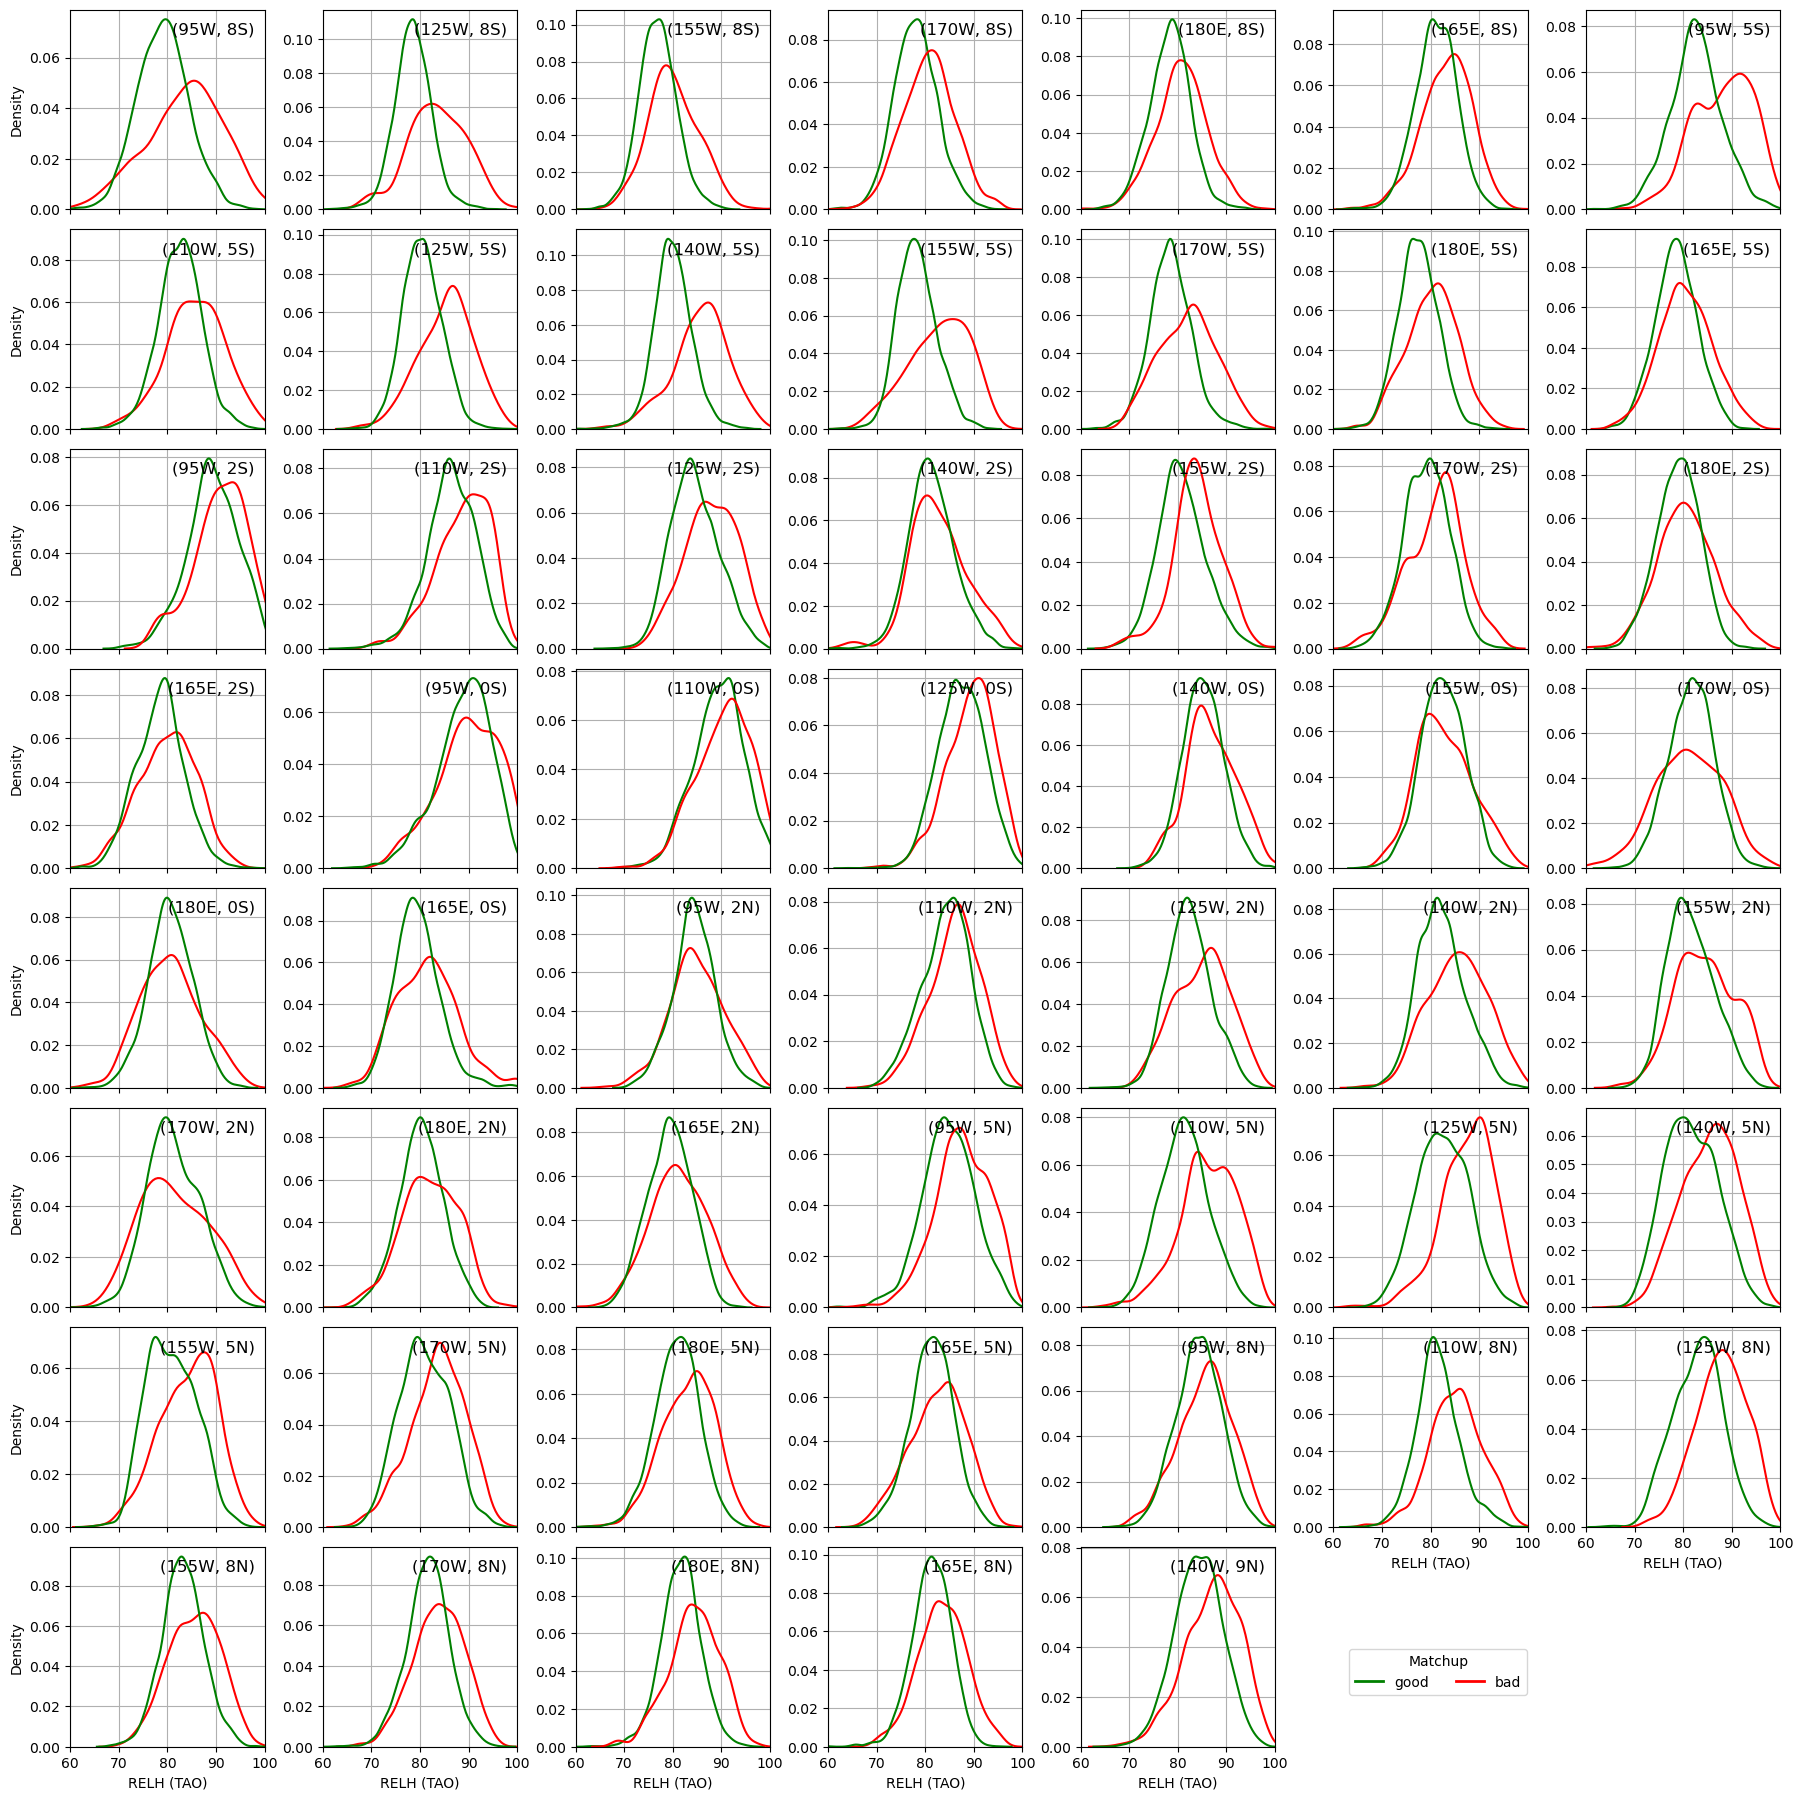

In [21]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

nsites = 7*8-2

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

nx = 7
ny = int(nsites//nx) + 1

#print('gird = ', nx*ny, nx, ny)

ylabel = 'Density'
xlabel = 'RELH (TAO)'
xtickLocs = np.linspace(60, 100, 5)
fig, axes  = plt.subplots(nrows = ny, ncols =nx, figsize = (18,18), sharex = False, sharey = False)

maxRowInEachCol = np.zeros(nx, dtype = int)

i= 0
j = 0
done = False
ncount = 0

while not done:
    task = taskList[j]

    ii = int(i//nx)
    jj = i%nx
    ax = axes[ii,jj]
    
    lat = task[0]
    lon = task[1]
    lon = (lon + 360)%360
    
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    
    if len(subDF)> 0:
        ncount += 1
        subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})    
        sns.kdeplot(subDF, x=xlabel, 
                     hue='Matchup Agreement', 
                     palette = {'good': 'green', 'bad': 'red'}, 
                     legend=False,
                     common_norm = False, 
                     ax = ax)
        
        ax.set_xlim(xtickLocs[0], xtickLocs[-1])
        ax.set_xticks(xtickLocs)
        ax.set_xticklabels([])
        ax.set_xlabel('')
        
        ax.grid(visible=True, which='major')

        lon180 = lon if lon <= 180 else lon - 360
        lonUnit = 'E' if lon180 > 0 else 'W' 
        latUnit = 'N' if lat > 0 else 'S'
        txt = f'({abs(lon180)}{lonUnit}, {abs(lat)}{latUnit})'
        
        ax.text(0.95, 0.9, txt, horizontalalignment='right',
                verticalalignment='center', transform=ax.transAxes,
                fontsize = 12)

        if jj == 0:
            ax.set_ylabel(ylabel)
        else:
            ax.set_ylabel('')
            
        if maxRowInEachCol[jj] < ii:
            maxRowInEachCol[jj] = ii
        i = i+1
        
    if j < len(taskList)-1:
        j=j+1
    else:
        done = True

# Hide unused subplots
for i in range(nsites, nx * ny):
    ii = int(i//nx)
    jj = i%nx
    fig.delaxes(axes[ii, jj])  # removes unused axes cleanly

for i in range(nx):
    ii = maxRowInEachCol[i]
    jj = i%nx
    axes[ii, jj].set_xticklabels([f'{val:2.0f}' for val in xtickLocs], ha='center')
    axes[ii, jj].set_xlabel(xlabel)

# 🌟 Add a single common legend
from matplotlib.lines import Line2D

# Custom legend handles
custom_lines = [
    Line2D([0], [0], color='green', lw=2, label='good'),
    Line2D([0], [0], color='red', lw=2, label='bad')
]

# Create the custom legend
fig.legend(
    handles=custom_lines,
    loc='lower center',
    ncol=len(custom_lines),
    bbox_to_anchor=(0.80, 0.05),
    title='Matchup'
)

plt.subplots_adjust(left = 0.04, right = 0.99, top = 0.99, bottom =0.025, wspace = 0.3, hspace = 0.1)
plt.savefig('frozen_pdf_RELH.pdf', dpi = 100)

#print(ncount)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

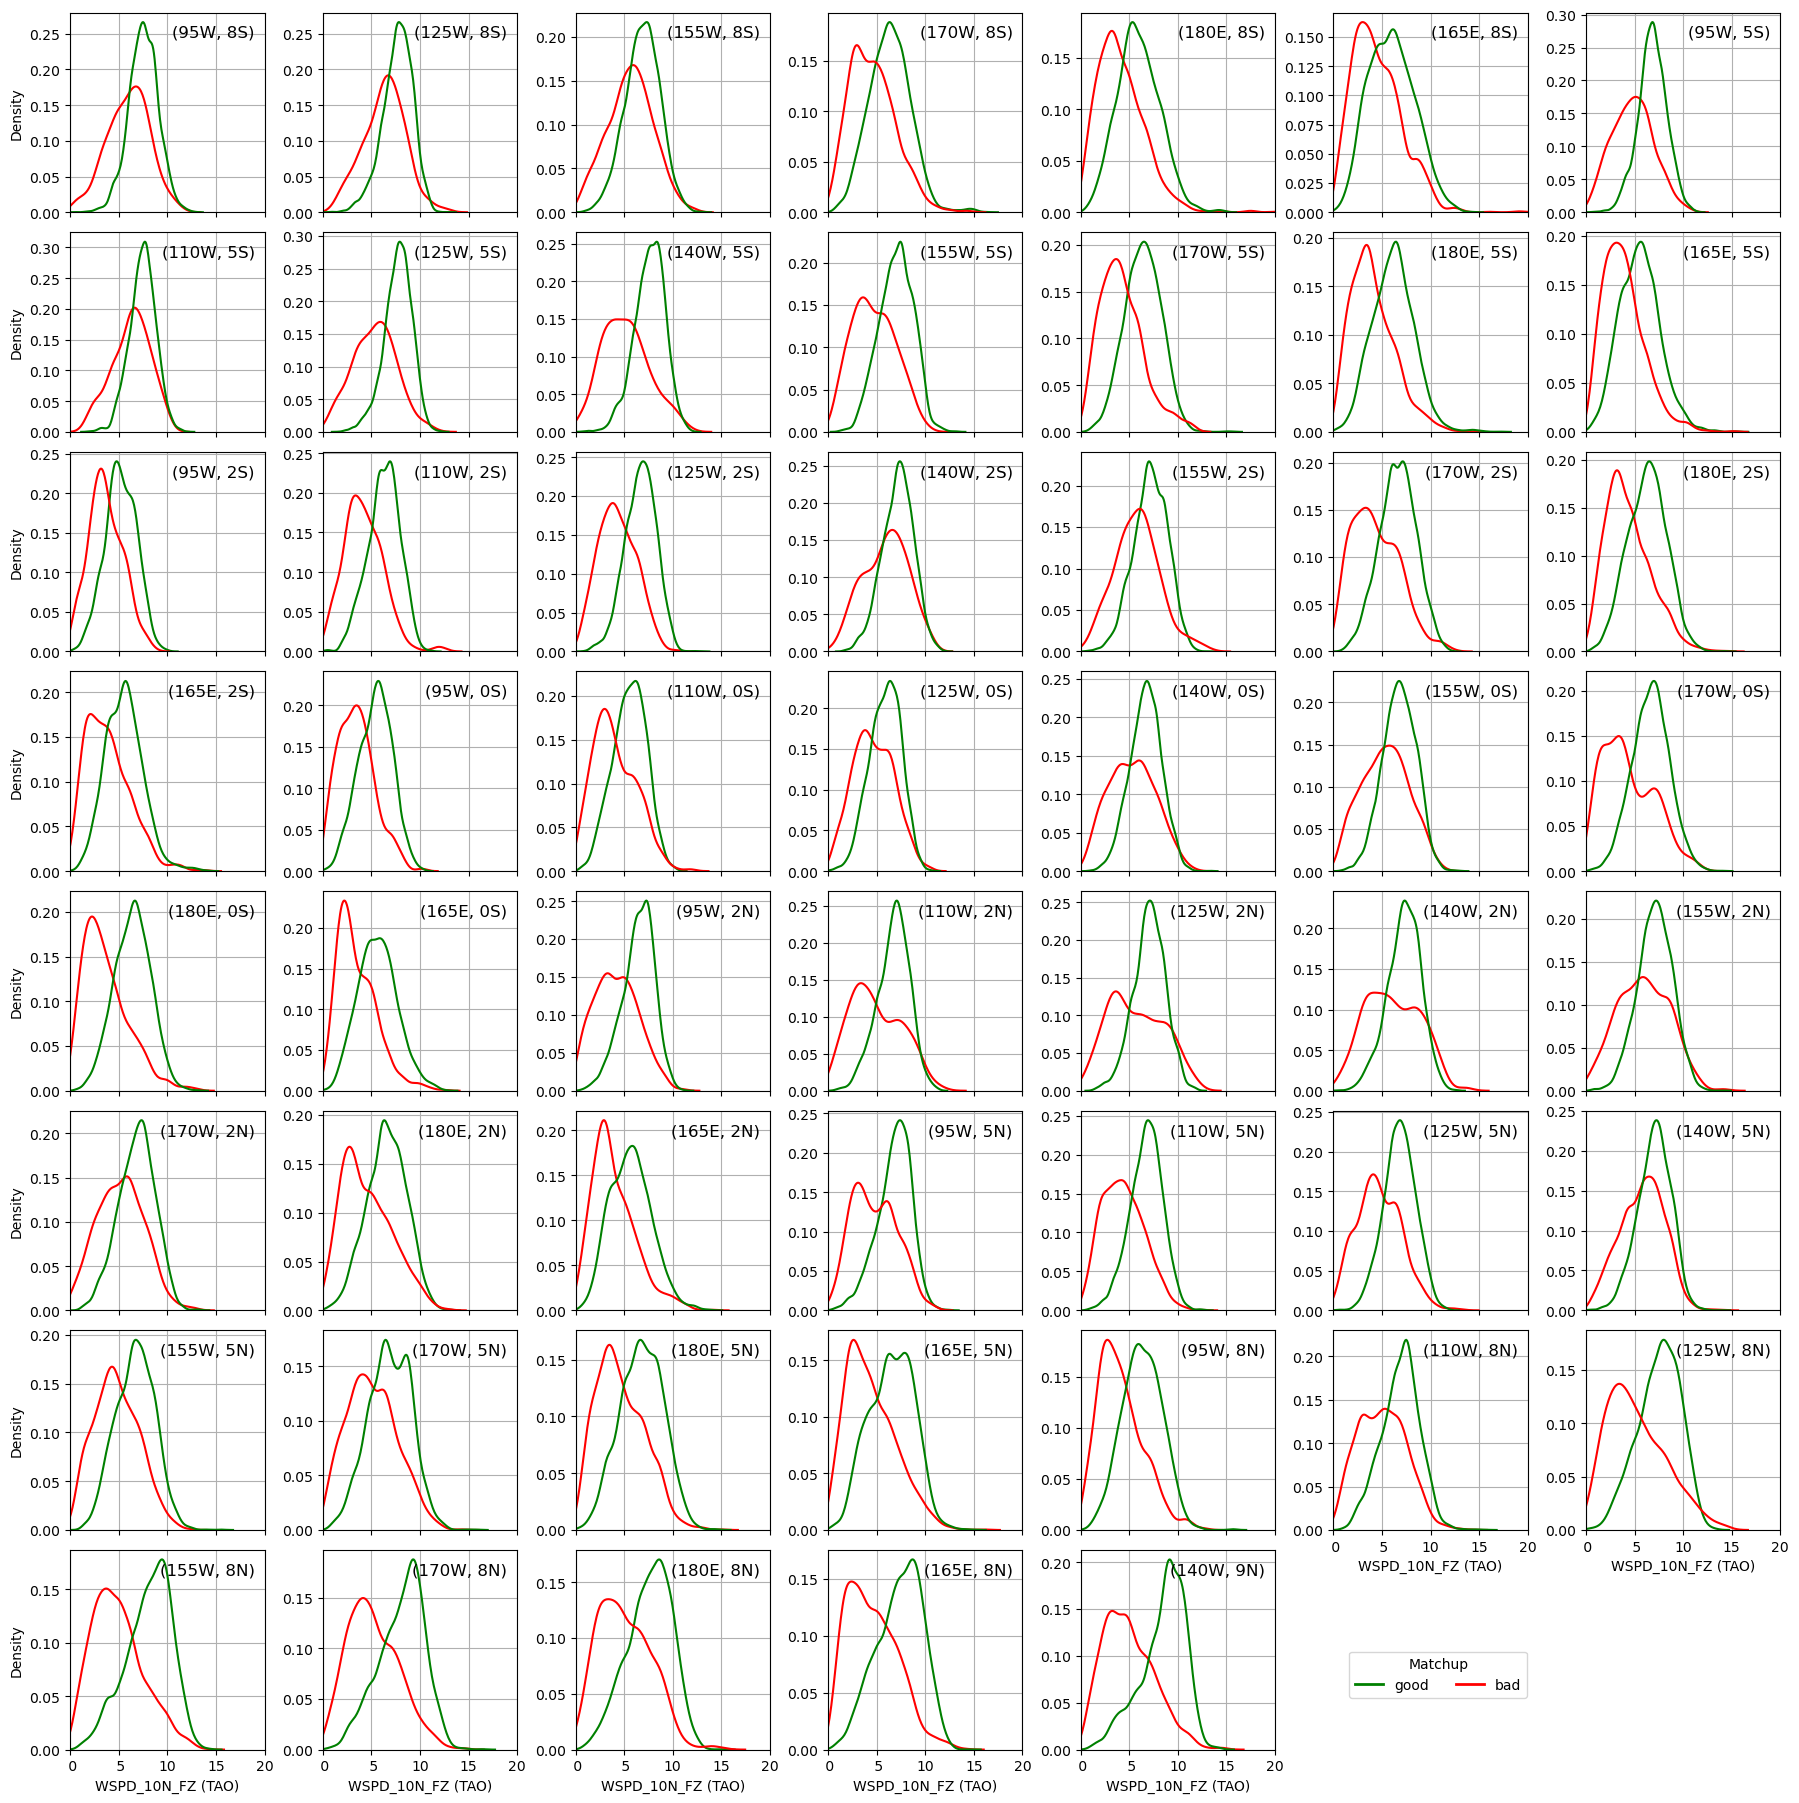

In [22]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

nsites = 7*8-2

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

nx = 7
ny = int(nsites//nx) + 1

#print('gird = ', nx*ny, nx, ny)

ylabel = 'Density'
xlabel = 'WSPD_10N_FZ (TAO)'
xtickLocs = np.linspace(0, 20, 5)
fig, axes  = plt.subplots(nrows = ny, ncols =nx, figsize = (18,18), sharex = False, sharey = False)

maxRowInEachCol = np.zeros(nx, dtype = int)

i= 0
j = 0
done = False
ncount = 0

while not done:
    task = taskList[j]

    ii = int(i//nx)
    jj = i%nx
    ax = axes[ii,jj]
    
    lat = task[0]
    lon = task[1]
    lon = (lon + 360)%360
    
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    
    if len(subDF)> 0:
        ncount += 1
        subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})    
        sns.kdeplot(subDF, x=xlabel, 
                     hue='Matchup Agreement', 
                     palette = {'good': 'green', 'bad': 'red'}, 
                     legend=False,
                     common_norm = False, 
                     ax = ax)
        
        ax.set_xlim(xtickLocs[0], xtickLocs[-1])
        ax.set_xticks(xtickLocs)
        ax.set_xticklabels([])
        ax.set_xlabel('')
        
        ax.grid(visible=True, which='major')

        lon180 = lon if lon <= 180 else lon - 360
        lonUnit = 'E' if lon180 > 0 else 'W' 
        latUnit = 'N' if lat > 0 else 'S'
        txt = f'({abs(lon180)}{lonUnit}, {abs(lat)}{latUnit})'
        
        ax.text(0.95, 0.9, txt, horizontalalignment='right',
                verticalalignment='center', transform=ax.transAxes,
                fontsize = 12)

        if jj == 0:
            ax.set_ylabel(ylabel)
        else:
            ax.set_ylabel('')
            
        if maxRowInEachCol[jj] < ii:
            maxRowInEachCol[jj] = ii
        i = i+1
        
    if j < len(taskList)-1:
        j=j+1
    else:
        done = True

# Hide unused subplots
for i in range(nsites, nx * ny):
    ii = int(i//nx)
    jj = i%nx
    fig.delaxes(axes[ii, jj])  # removes unused axes cleanly

for i in range(nx):
    ii = maxRowInEachCol[i]
    jj = i%nx
    axes[ii, jj].set_xticklabels([f'{val:2.0f}' for val in xtickLocs], ha='center')
    axes[ii, jj].set_xlabel(xlabel)

# 🌟 Add a single common legend
from matplotlib.lines import Line2D

# Custom legend handles
custom_lines = [
    Line2D([0], [0], color='green', lw=2, label='good'),
    Line2D([0], [0], color='red', lw=2, label='bad')
]

# Create the custom legend
fig.legend(
    handles=custom_lines,
    loc='lower center',
    ncol=len(custom_lines),
    bbox_to_anchor=(0.80, 0.05),
    title='Matchup'
)

plt.subplots_adjust(left = 0.04, right = 0.99, top = 0.99, bottom =0.025, wspace = 0.3, hspace = 0.1)
plt.savefig('frozen_pdf_WSPD_10N_FZ.pdf', dpi = 100)

#print(ncount)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

54


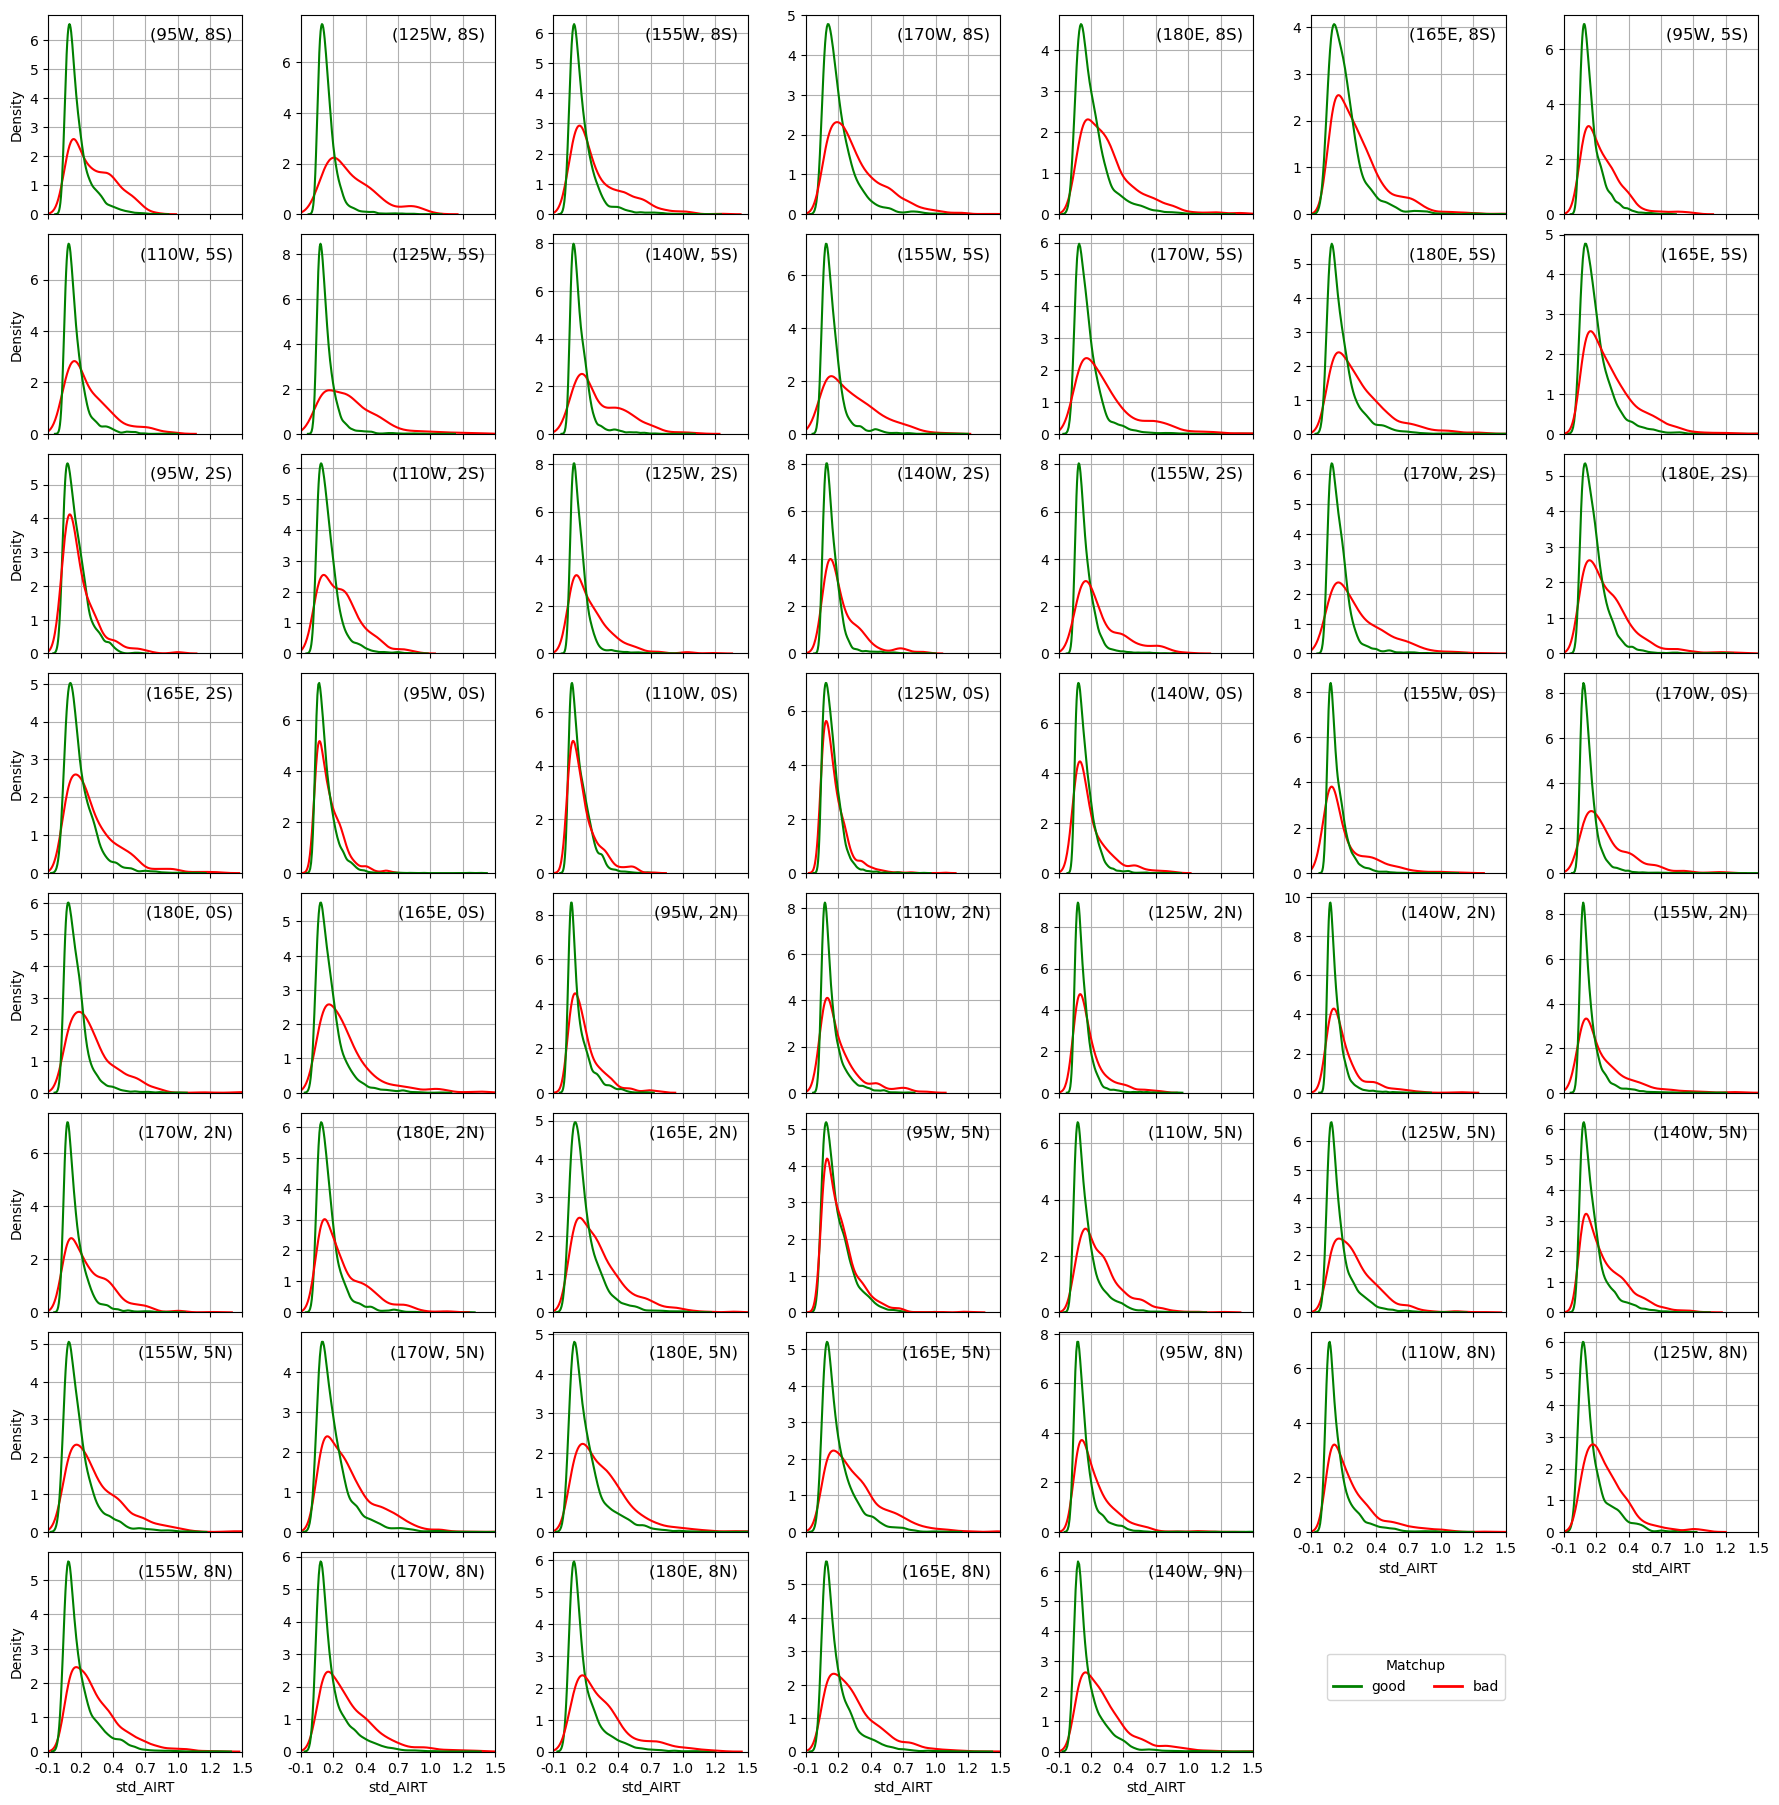

In [23]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

nsites = 7*8-2

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

nx = 7
ny = int(nsites//nx) + 1

#print('gird = ', nx*ny, nx, ny)

ylabel = 'Density'
xlabel = 'std_AIRT'
xtickLocs = np.linspace(-0.1, 1.5, 7)
fig, axes  = plt.subplots(nrows = ny, ncols =nx, figsize = (18,18), sharex = False, sharey = False)

maxRowInEachCol = np.zeros(nx, dtype = int)

i= 0
j = 0
done = False
ncount = 0

while not done:
    task = taskList[j]

    ii = int(i//nx)
    jj = i%nx
    ax = axes[ii,jj]
    
    lat = task[0]
    lon = task[1]
    lon = (lon + 360)%360
    
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    
    if len(subDF)> 0:
        ncount += 1
        subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})    
        sns.kdeplot(subDF, x=xlabel, 
                     hue='Matchup Agreement', 
                     palette = {'good': 'green', 'bad': 'red'}, 
                     legend=False,
                     common_norm = False, 
                     ax = ax)
        
        ax.set_xlim(xtickLocs[0], xtickLocs[-1])
        ax.set_xticks(xtickLocs)
        ax.set_xticklabels([])
        ax.set_xlabel('')
        
        ax.grid(visible=True, which='major')

        lon180 = lon if lon <= 180 else lon - 360
        lonUnit = 'E' if lon180 > 0 else 'W' 
        latUnit = 'N' if lat > 0 else 'S'
        txt = f'({abs(lon180)}{lonUnit}, {abs(lat)}{latUnit})'
        
        ax.text(0.95, 0.9, txt, horizontalalignment='right',
                verticalalignment='center', transform=ax.transAxes,
                fontsize = 12)

        if jj == 0:
            ax.set_ylabel(ylabel)
        else:
            ax.set_ylabel('')
            
        if maxRowInEachCol[jj] < ii:
            maxRowInEachCol[jj] = ii
        i = i+1
        
    if j < len(taskList)-1:
        j=j+1
    else:
        done = True

# Hide unused subplots
for i in range(nsites, nx * ny):
    ii = int(i//nx)
    jj = i%nx
    fig.delaxes(axes[ii, jj])  # removes unused axes cleanly

for i in range(nx):
    ii = maxRowInEachCol[i]
    jj = i%nx
    axes[ii, jj].set_xticklabels([f'{val:2.1f}' for val in xtickLocs], ha='center')
    axes[ii, jj].set_xlabel(xlabel)

# 🌟 Add a single common legend
from matplotlib.lines import Line2D

# Custom legend handles
custom_lines = [
    Line2D([0], [0], color='green', lw=2, label='good'),
    Line2D([0], [0], color='red', lw=2, label='bad')
]

# Create the custom legend
fig.legend(
    handles=custom_lines,
    loc='lower center',
    ncol=len(custom_lines),
    bbox_to_anchor=(0.80, 0.05),
    title='Matchup'
)

plt.subplots_adjust(left = 0.04, right = 0.99, top = 0.99, bottom =0.025, wspace = 0.3, hspace = 0.1)
plt.savefig(f'frozen_pdf_{xlabel}.pdf', dpi = 100)

print(ncount)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

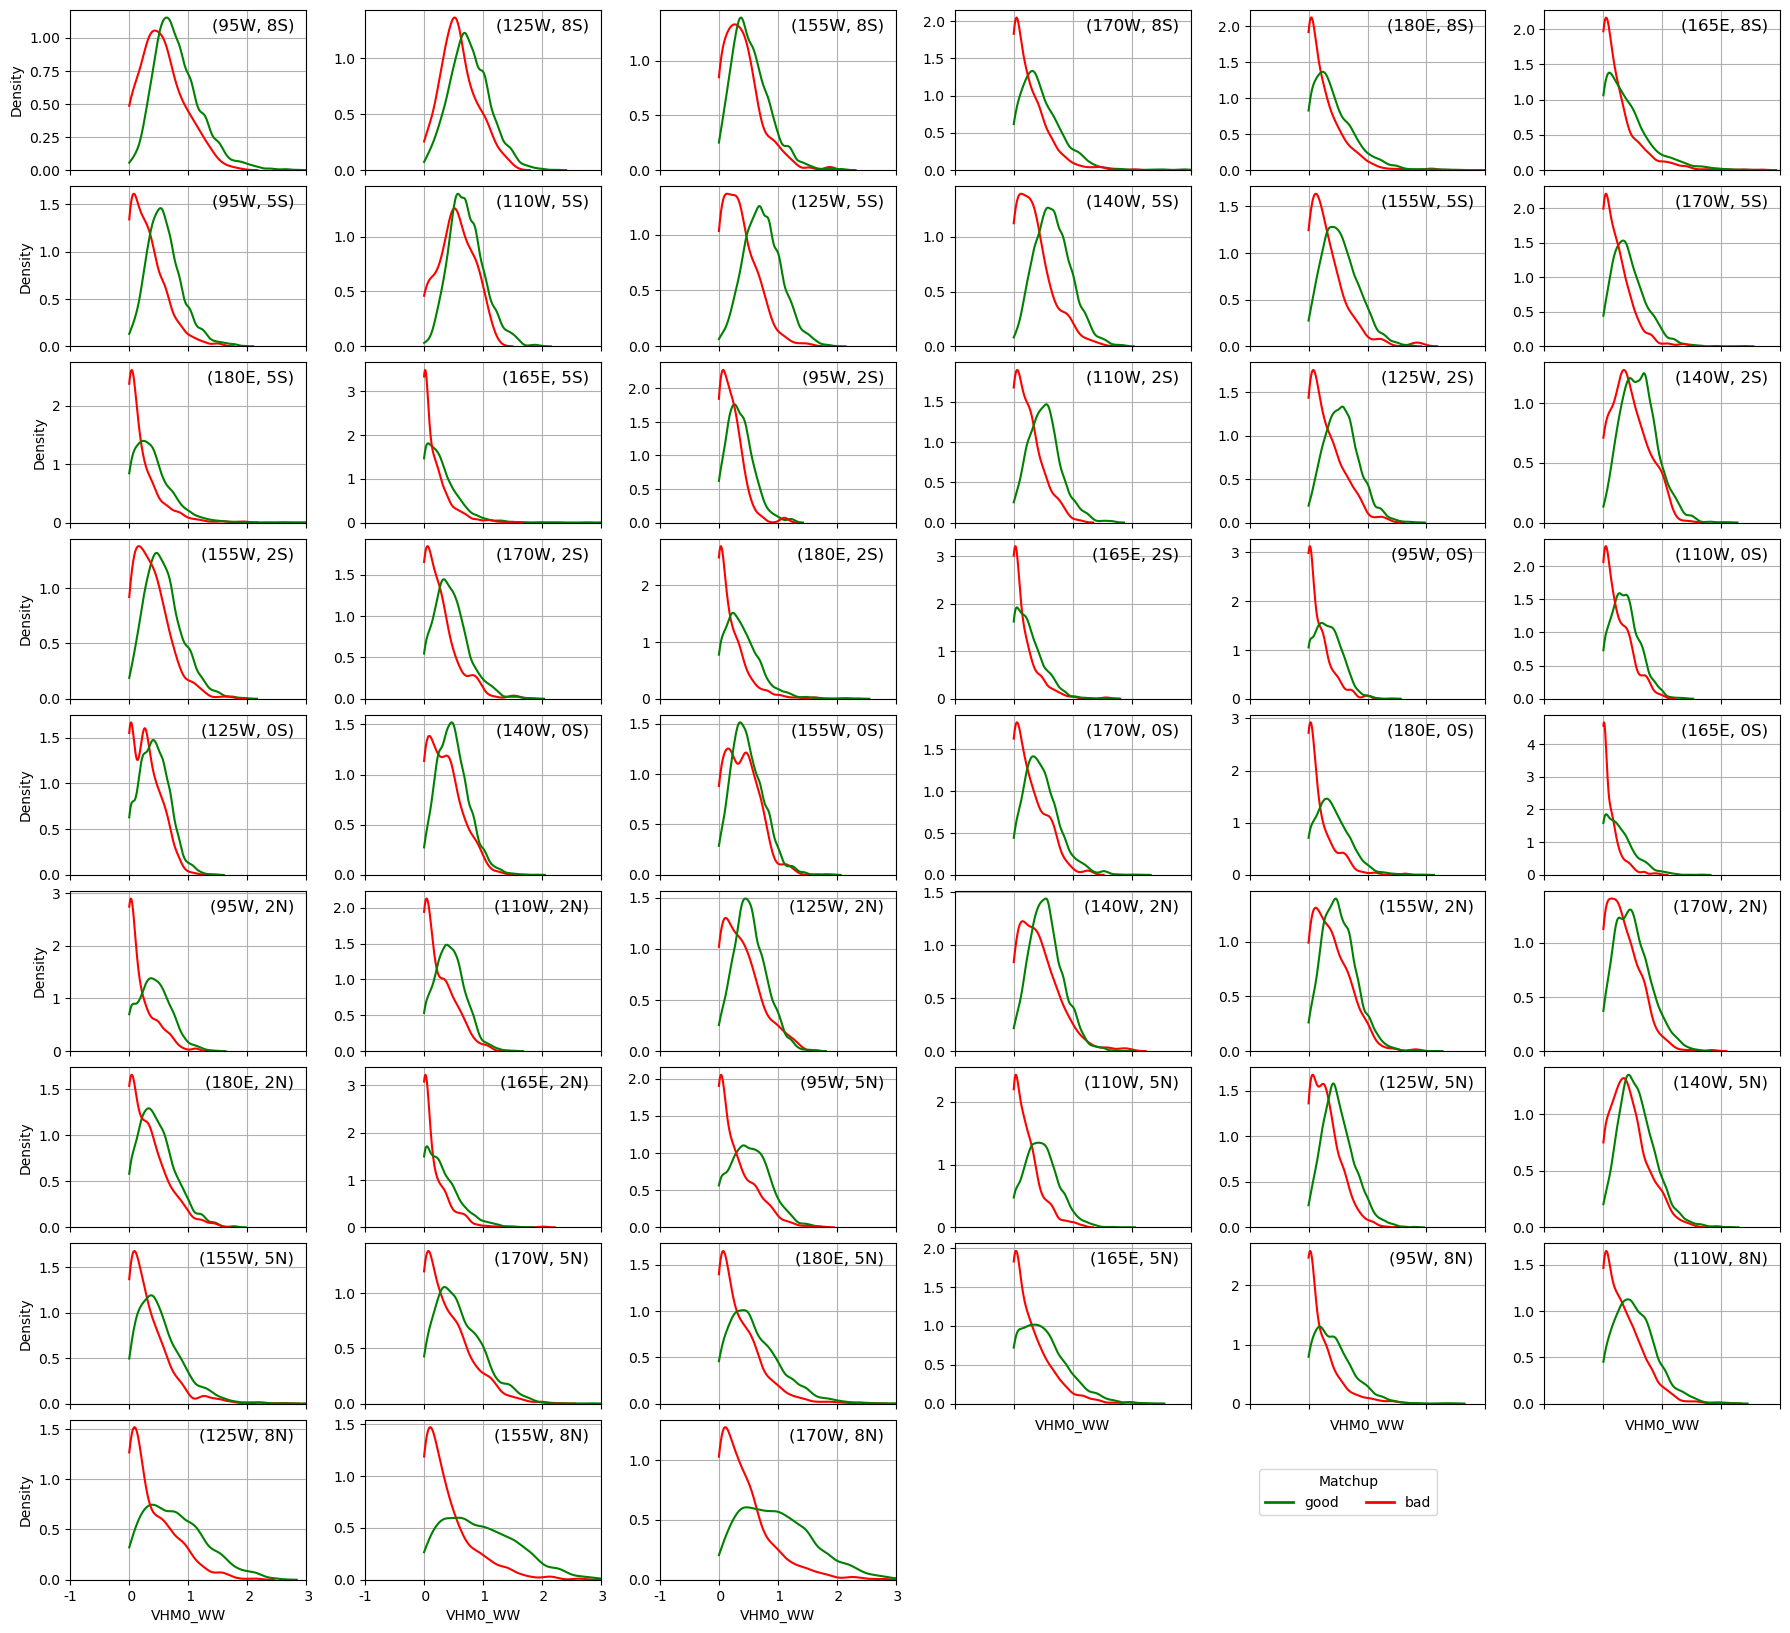

In [24]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

nx = 6
ny = int(56//nx) + 1
ylabel = 'Density'
xlabel = 'VHM0_WW'
xtickLocs = np.linspace(-1,3,5)
fig, axes  = plt.subplots(nrows = ny, ncols =nx, figsize = (18,18), sharex = False, sharey = False)

maxRowInEachCol = np.zeros(nx, dtype = int)
i= 0
j = 0
done = False
while not done:
    task = taskList[j]
    ii = int(i//nx)
    jj = i%nx
    ax = axes[ii,jj]
    
    
    
    title = 'For Buoy locations lon < -165 E '
    lat = task[0]
    lon = task[1]
    
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF)> 0:
        subDF = subDF.loc[subDF['WSPD (TAO)'] > 2]
        subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
        # goodDF = subDF.loc[subDF['GoodBad'] == 'good']
        # badDF = subDF.loc[subDF['GoodBad'] == 'bad']
        
        sns.kdeplot(subDF, x=xlabel, 
                     clip = (0,3), #cut = 0, bw_adjust=0.5,
                     hue='Matchup Agreement', 
                     #multiple=histkind,
                     palette = {'good': 'green', 'bad': 'red'}, 
                     legend=False,
                     #hue_order=stack_order,
                     common_norm = False, 
                     ax = ax)
        ax.set_xlim(xtickLocs[0], xtickLocs[-1])
        ax.set_xticks(xtickLocs)
        ax.set_xticklabels([])
        ax.grid(visible=True, which='major')

        lon180 = lon if lon <= 180 else lon - 360
        
        lonUnit = 'E' if lon180 > 0 else 'W' 
        latUnit = 'N' if lat > 0 else 'S'
        txt = f'({abs(lon180)}{lonUnit}, {abs(lat)}{latUnit})'
        
        ax.text(0.95, 0.9, txt, horizontalalignment='right',
                verticalalignment='center', transform=ax.transAxes,
                fontsize = 12)


        if jj == 0:
            ax.set_ylabel(ylabel)
        else:
            ax.set_ylabel('')
        if maxRowInEachCol[jj] < ii:
            maxRowInEachCol[jj] = ii
    
        i = i+1
    if j < len(taskList)-1:
        j=j+1
    else:
        done = True

# Hide unused subplots
for i in range(51, nx * ny):
    ii = int(i//nx)
    jj = i%nx
    fig.delaxes(axes[ii, jj])  # removes unused axes cleanly


for i in range(nx):
    ii = maxRowInEachCol[i]
    jj = i%nx
    axes[ii, jj].set_xticklabels([f'{val:2.0f}' for val in xtickLocs], ha='center')

# 🌟 Add a single common legend
from matplotlib.lines import Line2D

# Custom legend handles
custom_lines = [
    Line2D([0], [0], color='green', lw=2, label='good'),
    Line2D([0], [0], color='red', lw=2, label='bad')
]

# Create the custom legend
fig.legend(
    handles=custom_lines,
    loc='lower center',
    ncol=len(custom_lines),
    bbox_to_anchor=(0.75, 0.15),
    title='Matchup'
)

plt.subplots_adjust(left = 0.04, right = 0.99, top = 0.99, bottom =0.02, wspace = 0.25, hspace = 0.1)
plt.savefig(f'frozen_{xlabel}.pdf', dpi = 100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

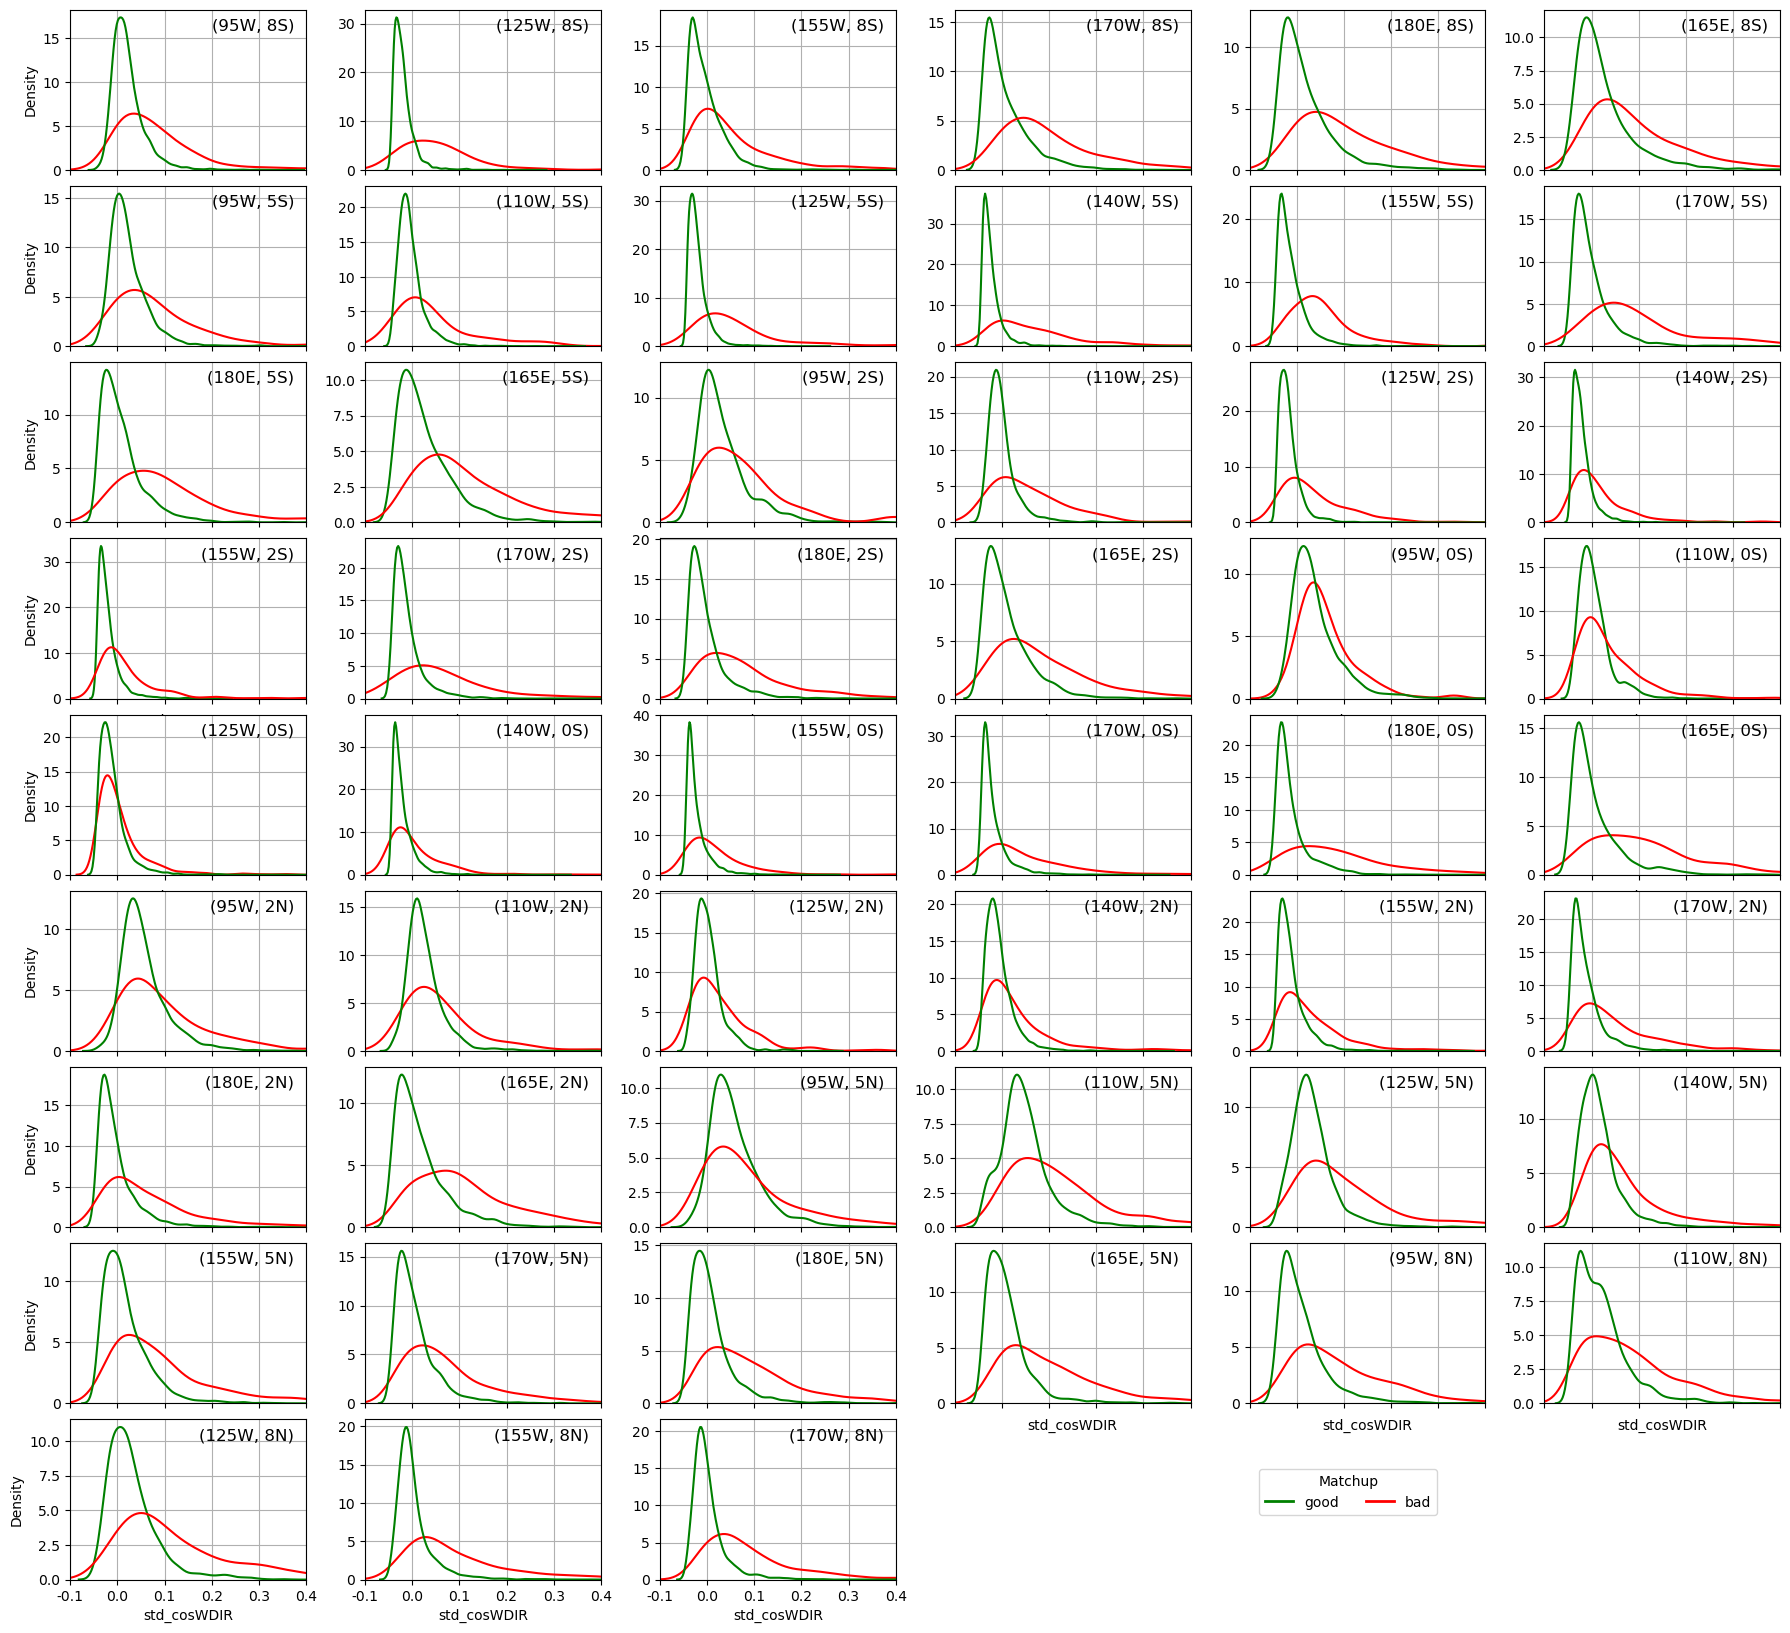

In [25]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

nx = 6
ny = int(56//nx) + 1
ylabel = 'Density'
xlabel = 'std_cosWDIR'#_DIR-mean_WDIR'
c1, c2 = -0.05,0.4
x1, x2 = -0.05,0.4
xtickLocs = np.linspace(x1,x2,6)
fig, axes  = plt.subplots(nrows = ny, ncols =nx, figsize = (18,18), sharex = False, sharey = False)

maxRowInEachCol = np.zeros(nx, dtype = int)
i= 0
j = 0
done = False
while not done:
    task = taskList[j]
    ii = int(i//nx)
    jj = i%nx
    ax = axes[ii,jj]
    
    
    
    title = 'For Buoy locations lon < -165 E '
    lat = task[0]
    lon = task[1]
    
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF)> 0:
        subDF = subDF.loc[subDF['WSPD (TAO)'] > 2]
        subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
        # goodDF = subDF.loc[subDF['GoodBad'] == 'good']
        # badDF = subDF.loc[subDF['GoodBad'] == 'bad']
        
        sns.kdeplot(subDF, x=xlabel, 
                     clip = (c1,c2), #cut = 0, bw_adjust=0.5,
                     hue='Matchup Agreement', 
                     #multiple=histkind,
                     palette = {'good': 'green', 'bad': 'red'}, 
                     legend=False,
                     #hue_order=stack_order,
                     common_norm = False, 
                     ax = ax)
        ax.set_xlim(xtickLocs[0], xtickLocs[-1])
        ax.set_xticks(xtickLocs)
        ax.set_xticklabels([])
        ax.grid(visible=True, which='major')

        lon180 = lon if lon <= 180 else lon - 360
        
        lonUnit = 'E' if lon180 > 0 else 'W' 
        latUnit = 'N' if lat > 0 else 'S'
        txt = f'({abs(lon180)}{lonUnit}, {abs(lat)}{latUnit})'
        
        ax.text(0.95, 0.9, txt, horizontalalignment='right',
                verticalalignment='center', transform=ax.transAxes,
                fontsize = 12)


        if jj == 0:
            ax.set_ylabel(ylabel)
        else:
            ax.set_ylabel('')
        if maxRowInEachCol[jj] < ii:
            maxRowInEachCol[jj] = ii
    
        i = i+1
    if j < len(taskList)-1:
        j=j+1
    else:
        done = True

# Hide unused subplots
for i in range(51, nx * ny):
    ii = int(i//nx)
    jj = i%nx
    fig.delaxes(axes[ii, jj])  # removes unused axes cleanly


for i in range(nx):
    ii = maxRowInEachCol[i]
    jj = i%nx
    axes[ii, jj].set_xticklabels([f'{val:3.1f}' for val in xtickLocs], ha='center')

# 🌟 Add a single common legend
from matplotlib.lines import Line2D

# Custom legend handles
custom_lines = [
    Line2D([0], [0], color='green', lw=2, label='good'),
    Line2D([0], [0], color='red', lw=2, label='bad')
]

# Create the custom legend
fig.legend(
    handles=custom_lines,
    loc='lower center',
    ncol=len(custom_lines),
    bbox_to_anchor=(0.75, 0.15),
    title='Matchup'
)

plt.subplots_adjust(left = 0.04, right = 0.99, top = 0.99, bottom =0.02, wspace = 0.25, hspace = 0.1)
plt.savefig(f'frozen_{xlabel}.pdf', dpi = 100)

In [ ]:
np.min(df['VSD_DIR'].to_numpy()), np.max(df['VSD_DIR'].to_numpy())

In [ ]:
sns.kdeplot(df, x='VSD_DIR')

In [ ]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

nx = 6
ny = int(51//nx) + 1
ylabel = 'Density'
xlabel = 'std. dev. cosWDIR 120min'
xtickLocs = np.linspace(-0.05, 0.4, 6)
fig, axes  = plt.subplots(nrows = ny, ncols =nx, figsize = (18,18), sharex = False, sharey = False)

maxRowInEachCol = np.zeros(nx, dtype = int)
i= 0
j = 0
done = False
while not done:
    task = taskList[j]
    ii = int(i//nx)
    jj = i%nx
    ax = axes[ii,jj]
    
    
    
    title = 'For Buoy locations lon < -165 E '
    lat = task[0]
    lon = task[1]
    
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF)> 0:
        subDF = subDF.loc[subDF['WSPD (TAO)'] > 2]
        subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
        # goodDF = subDF.loc[subDF['GoodBad'] == 'good']
        # badDF = subDF.loc[subDF['GoodBad'] == 'bad']
        
        sns.kdeplot(subDF, x=xlabel, 
                     #clip = (60,100), cut = 0, bw_adjust=0.5,
                     hue='Matchup Agreement', 
                     #multiple=histkind,
                     palette = {'good': 'green', 'bad': 'red'}, 
                    legend=False,
                     #hue_order=stack_order,
                     common_norm = False, 
                     ax = ax)
        ax.set_xlim(xtickLocs[0], xtickLocs[-1])
        ax.set_xticks(xtickLocs)
        ax.set_xticklabels([])
        ax.grid(visible=True, which='major')

        lon180 = lon if lon <= 180 else lon - 360
        
        lonUnit = 'E' if lon180 > 0 else 'W' 
        latUnit = 'N' if lat > 0 else 'S'
        txt = f'({abs(lon180)}{lonUnit}, {abs(lat)}{latUnit})'
        
        ax.text(0.95, 0.9, txt, horizontalalignment='right',
                verticalalignment='center', transform=ax.transAxes,
                fontsize = 12)


        if jj == 0:
            ax.set_ylabel(ylabel)
        else:
            ax.set_ylabel('')
        if maxRowInEachCol[jj] < ii:
            maxRowInEachCol[jj] = ii
    
        i = i+1
    if j < len(taskList)-1:
        j=j+1
    else:
        done = True

# Hide unused subplots
for i in range(51, nx * ny):
    ii = int(i//nx)
    jj = i%nx
    fig.delaxes(axes[ii, jj])  # removes unused axes cleanly


for i in range(nx):
    ii = maxRowInEachCol[i]
    jj = i%nx
    axes[ii, jj].set_xticklabels([f'{val:4.2f}' for val in xtickLocs], ha='center')
    xlabel = 'std. dev. Cos Wind Dir. (TAO) \n [120 min Window]'
    axes[ii, jj].set_xlabel(xlabel)

# 🌟 Add a single common legend
from matplotlib.lines import Line2D

# Custom legend handles
custom_lines = [
    Line2D([0], [0], color='green', lw=2, label='good'),
    Line2D([0], [0], color='red', lw=2, label='bad')
]

# Create the custom legend
fig.legend(
    handles=custom_lines,
    loc='lower center',
    ncol=len(custom_lines),
    bbox_to_anchor=(0.75, 0.04),
    title='Matchup'
)


plt.subplots_adjust(left = 0.04, right = 0.99, top = 0.99, bottom =0.04, wspace = 0.25, hspace = 0.05)
plt.savefig('pdf_std_cosWDIR.pdf', dpi = 100)

In [ ]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

nx = 6
ny = int(51//nx) + 1
ylabel = 'Density'
xlabel = 'std. dev. sinWDIR 120min'
xtickLocs = np.linspace(-0.05, 0.5, 6)
fig, axes  = plt.subplots(nrows = ny, ncols =nx, figsize = (18,18), sharex = False, sharey = False)

maxRowInEachCol = np.zeros(nx, dtype = int)
i= 0
j = 0
done = False
while not done:
    task = taskList[j]
    ii = int(i//nx)
    jj = i%nx
    ax = axes[ii,jj]
    
    
    
    title = 'For Buoy locations lon < -165 E '
    lat = task[0]
    lon = task[1]
    
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF)> 0:
        subDF = subDF.loc[subDF['WSPD (TAO)'] > 2]
        subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
        # goodDF = subDF.loc[subDF['GoodBad'] == 'good']
        # badDF = subDF.loc[subDF['GoodBad'] == 'bad']
        
        sns.kdeplot(subDF, x=xlabel, 
                     #clip = (60,100), cut = 0, bw_adjust=0.5,
                     hue='Matchup Agreement', 
                     #multiple=histkind,
                     palette = {'good': 'green', 'bad': 'red'}, 
                    legend=False,
                     #hue_order=stack_order,
                     common_norm = False, 
                     ax = ax)
        ax.set_xlim(xtickLocs[0], xtickLocs[-1])
        ax.set_xticks(xtickLocs)
        ax.set_xticklabels([])
        ax.grid(visible=True, which='major')

        lon180 = lon if lon <= 180 else lon - 360
        
        lonUnit = 'E' if lon180 > 0 else 'W' 
        latUnit = 'N' if lat > 0 else 'S'
        txt = f'({abs(lon180)}{lonUnit}, {abs(lat)}{latUnit})'
        
        ax.text(0.95, 0.9, txt, horizontalalignment='right',
                verticalalignment='center', transform=ax.transAxes,
                fontsize = 12)


        if jj == 0:
            ax.set_ylabel(ylabel)
        else:
            ax.set_ylabel('')
        if maxRowInEachCol[jj] < ii:
            maxRowInEachCol[jj] = ii
    
        i = i+1
    if j < len(taskList)-1:
        j=j+1
    else:
        done = True

# Hide unused subplots
for i in range(51, nx * ny):
    ii = int(i//nx)
    jj = i%nx
    fig.delaxes(axes[ii, jj])  # removes unused axes cleanly


for i in range(nx):
    ii = maxRowInEachCol[i]
    jj = i%nx
    axes[ii, jj].set_xticklabels([f'{val:4.2f}' for val in xtickLocs], ha='center')
    xlabel = 'std. dev. Sin Wind Dir. (TAO) \n [120 min Window]'
    axes[ii, jj].set_xlabel(xlabel)

# 🌟 Add a single common legend
from matplotlib.lines import Line2D

# Custom legend handles
custom_lines = [
    Line2D([0], [0], color='green', lw=2, label='good'),
    Line2D([0], [0], color='red', lw=2, label='bad')
]

# Create the custom legend
fig.legend(
    handles=custom_lines,
    loc='lower center',
    ncol=len(custom_lines),
    bbox_to_anchor=(0.75, 0.04),
    title='Matchup'
)


plt.subplots_adjust(left = 0.04, right = 0.99, top = 0.99, bottom =0.04, wspace = 0.25, hspace = 0.05)
plt.savefig('pdf_std_sinWDIR.pdf', dpi = 100)